# Seawater Model

This Jupyter notebook (Python 3 kernel) develops the seawater model, and plots results obtained in the `Paleogeography_Analysis.ipynb` notebook.

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import statsmodels.api as sm
import matplotlib.patches as patches

Plotting functions:

In [2]:
from Seawater_Model_Functions import plot_seawater_model
from Seawater_Model_Functions import plot_model_and_data
from Seawater_Model_Functions import dict_to_sorted_df

## Composite Sr Isotope Data

As developed in `Tonian_Cryogenian_Composite.ipynb`:

In [3]:
all_tonian_composite = pd.read_csv('../Composite_Chemostratigraphy/Data/Tonian_Cryogenian_Composite_data.csv')
all_tonian_composite.sort_values('age', inplace=True)
all_tonian_composite.reset_index(drop=True, inplace=True)

### LOWESS Fit

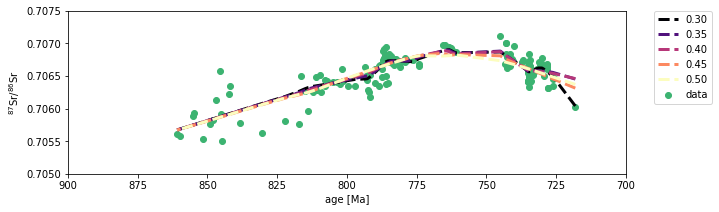

In [4]:
# pull out data for 900-700Ma
tonian_composite = all_tonian_composite[(all_tonian_composite['age']<=900) & (all_tonian_composite['age']>=700)].copy()
tonian_composite.sort_values('age', inplace=True)
tonian_composite.reset_index(drop=True,inplace=True)

# LOWESS fits
xy_30 = sm.nonparametric.lowess(tonian_composite['87Sr/86Sr_primary'], tonian_composite['age'], frac=0.30)
xy_35 = sm.nonparametric.lowess(tonian_composite['87Sr/86Sr_primary'], tonian_composite['age'], frac=0.35)
xy_40 = sm.nonparametric.lowess(tonian_composite['87Sr/86Sr_primary'], tonian_composite['age'], frac=0.40)
xy_45 = sm.nonparametric.lowess(tonian_composite['87Sr/86Sr_primary'], tonian_composite['age'], frac=0.45)
xy_50 = sm.nonparametric.lowess(tonian_composite['87Sr/86Sr_primary'], tonian_composite['age'], frac=0.50)

# colormaps
cm_subsection = np.linspace(0, 1, 5)
colors = [cm.magma(x) for x in cm_subsection]

# plot
fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(tonian_composite['age'],tonian_composite['87Sr/86Sr_primary'], c='mediumseagreen', label='data')
ax.plot(xy_30[:,0], xy_30[:,1], c=colors[0], lw=3, ls='--', label='0.30')
ax.plot(xy_35[:,0], xy_35[:,1], c=colors[1], lw=3, ls='--', label='0.35')
ax.plot(xy_40[:,0], xy_40[:,1], c=colors[2], lw=3, ls='--', label='0.40')
ax.plot(xy_45[:,0], xy_45[:,1], c=colors[3], lw=3, ls='--', label='0.45')
ax.plot(xy_50[:,0], xy_50[:,1], c=colors[4], lw=3, ls='--', label='0.50')
ax.set_xlim(900,700)
ax.set_ylim(0.705, 0.7075)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show(fig)

We find that using 45% of the data to make the LOWESS fit produces a curve that neither over- nor under-fits the data.

In [5]:
xy = xy_45

## LIPs

In [6]:
pre_sturt_composite = all_tonian_composite[all_tonian_composite['age']>=700].copy()

tambien_data = pre_sturt_composite[pre_sturt_composite['formation']=='Tambien Group'].copy()

pre_sturt_xy = sm.nonparametric.lowess(pre_sturt_composite['87Sr/86Sr_primary'], pre_sturt_composite['age'], frac=0.40)

LIP emplacement:

In [7]:
LIP_emplacement = pd.read_csv('LIP_emplacement.csv', index_col=0)

# set up the time vector
t_start_emplacement = 1267
t_stop_emplacement = 700
t_step = -1
ts_emplacement = np.arange(t_start_emplacement, t_stop_emplacement+t_step, t_step)

# separate constrained and unconstrained LIPs
constrained_LIPs = LIP_emplacement[(LIP_emplacement['name']!='Dashigou')&
                                   (LIP_emplacement['name']!='Gangil-Mayumbia')&
                                   (LIP_emplacement['name']!='Willouran-Gairdner')&
                                   (LIP_emplacement['name']!='Irkutsk')].copy()
unconstrained_LIPs = LIP_emplacement[(LIP_emplacement['name']=='Dashigou')|
                                     (LIP_emplacement['name']=='Gangil-Mayumbia')|
                                     (LIP_emplacement['name']=='Willouran-Gairdner')|
                                     (LIP_emplacement['name']=='Irkutsk')].copy()
constrained_LIPs.reset_index(drop=True, inplace=True)
unconstrained_LIPs.reset_index(drop=True, inplace=True)

# merge some unconstrained polygons and create arrays with area, age, lat
unconstrained_LIPs_area = np.array([])
unconstrained_LIPs_age = np.array([])
unconstrained_LIPs_lat = np.array([])
for i in range(len(unconstrained_LIPs.index)):
    if unconstrained_LIPs['name'][i]!='Willouran-Gairdner':
        unconstrained_LIPs_area = np.append(unconstrained_LIPs_area, unconstrained_LIPs['emplacement_area_km2'][i])
        unconstrained_LIPs_age = np.append(unconstrained_LIPs_age, unconstrained_LIPs['emplacement_age'][i])
        unconstrained_LIPs_lat = np.append(unconstrained_LIPs_lat, unconstrained_LIPs['emplacement_lat'][i])

temp = unconstrained_LIPs[unconstrained_LIPs['name']=='Willouran-Gairdner'].copy()
temp.reset_index(drop=True,inplace=True)
area = 0
for i in range(len(temp.index)):
    area = area + temp['emplacement_area_km2'][i]
unconstrained_LIPs_area = np.append(unconstrained_LIPs_area, area)
unconstrained_LIPs_age = np.append(unconstrained_LIPs_age, temp['emplacement_age'][0])
unconstrained_LIPs_lat = np.append(unconstrained_LIPs_lat, temp['emplacement_lat'][0])

# merge some constrained polygons and create arrays with area, age, lat
constrained_LIPs_area = np.array([])
constrained_LIPs_age = np.array([])
constrained_LIPs_lat = np.array([])
for i in range(len(constrained_LIPs.index)):
    if constrained_LIPs['name'][i]!='Gunbarrel' and constrained_LIPs['name'][i]!='SWCUC' and constrained_LIPs['name'][i]!='Warakurna':
        constrained_LIPs_area = np.append(constrained_LIPs_area, constrained_LIPs['emplacement_area_km2'][i])
        constrained_LIPs_age = np.append(constrained_LIPs_age, constrained_LIPs['emplacement_age'][i])
        constrained_LIPs_lat = np.append(constrained_LIPs_lat, constrained_LIPs['emplacement_lat'][i])

temp = constrained_LIPs[constrained_LIPs['name']=='Gunbarrel'].copy()
temp.reset_index(drop=True,inplace=True)
area = 0
for i in range(len(temp.index)):
    area = area + temp['emplacement_area_km2'][i]
constrained_LIPs_area = np.append(constrained_LIPs_area, area)
constrained_LIPs_age = np.append(constrained_LIPs_age, temp['emplacement_age'][0])
constrained_LIPs_lat = np.append(constrained_LIPs_lat, temp['emplacement_lat'][0])

temp = constrained_LIPs[constrained_LIPs['name']=='SWCUC'].copy()
temp.reset_index(drop=True,inplace=True)
area = 0
for i in range(len(temp.index)):
    area = area + temp['emplacement_area_km2'][i]
constrained_LIPs_area = np.append(constrained_LIPs_area, area)
constrained_LIPs_age = np.append(constrained_LIPs_age, temp['emplacement_age'][0])
constrained_LIPs_lat = np.append(constrained_LIPs_lat, temp['emplacement_lat'][0])

temp = constrained_LIPs[constrained_LIPs['name']=='Warakurna'].copy()
temp.reset_index(drop=True,inplace=True)
area = 0
for i in range(len(temp.index)):
    area = area + temp['emplacement_area_km2'][i]
constrained_LIPs_area = np.append(constrained_LIPs_area, area)
constrained_LIPs_age = np.append(constrained_LIPs_age, temp['emplacement_age'][0])
constrained_LIPs_lat = np.append(constrained_LIPs_lat, temp['emplacement_lat'][0])

# constrained LIP centroids - just get the centroid columns
drop_inds = []
Gunbarrel_check = False
SWCUC_check = False
Warakurna_check = False
for i in range(len(constrained_LIPs.index)):
    if constrained_LIPs['name'][i]=='Gunbarrel':
        if Gunbarrel_check:
            drop_inds.append(i)
        else:
            Gunbarrel_check = True
    elif constrained_LIPs['name'][i]=='SWCUC':
        if SWCUC_check:
            drop_inds.append(i)
        else:
            SWCUC_check = True
    elif constrained_LIPs['name'][i]=='Warakurna':
        if Warakurna_check:
            drop_inds.append(i)
        else:
            Warakurna_check

constrained_LIP_centroids = constrained_LIPs.values[:,6:]
constrained_LIP_centroids = np.delete(constrained_LIP_centroids, drop_inds, 0)

Tropical LIPs:

In [8]:
calc_abs_areas_LIPs = pd.read_csv('calc_abs_areas_LIPs.csv')
calc_abs_areas_LIPs_decay = pd.read_csv('calc_abs_areas_LIPs_decay.csv')
calc_abs_areas_LIPs_cover = pd.read_csv('calc_abs_areas_LIPs_cover.csv')

# just get from 1267 to 700 Ma
tropical_LIPs = calc_abs_areas_LIPs.values[0,6:]
tropical_LIPs = tropical_LIPs[:len(ts_emplacement)]

tropical_LIPs_decay = calc_abs_areas_LIPs_decay.values[0,6:]
tropical_LIPs_decay = tropical_LIPs_decay[:len(ts_emplacement)]

tropical_LIPs_cover = calc_abs_areas_LIPs_cover.values[0,6:]
tropical_LIPs_cover = tropical_LIPs_cover[:len(ts_emplacement)]

Arc accretion:

In [9]:
arc_accretion = pd.read_csv('arc_accretion.csv', index_col=0)

# the 6 index refers to 1267 Ma

# Arabian-Nubian stage a - Johnson2003a
ANa_start = 780
ANa_end = 760
ANa1_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 1'].values[0,6:].copy()
ANa1_AA = np.abs(ANa1_AA[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)])
ANa1_AA_ts = ts_emplacement[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)]

ANa2I_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 2-India'].values[0,6:].copy()
ANa2I_AA = np.abs(ANa2I_AA[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)])
ANa2I_AA_ts = ts_emplacement[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)]

ANa2A_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 2-Africa'].values[0,6:].copy()
ANa2A_AA = np.abs(ANa2A_AA[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)])
ANa2A_AA_ts = ts_emplacement[(ts_emplacement<=ANa_start) & (ts_emplacement>=ANa_end)]

ANa2_AA_max = np.array([])
for i in range(len(ANa2I_AA)):
    maxi = np.max([ANa2I_AA[i], ANa2A_AA[i]])
    ANa2_AA_max = np.append(ANa2_AA_max, maxi)

# Arabian-Nubian stage b - Ali2010a
ANb_start = 730
ANb_end = 709
ANb1_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 1'].values[0,6:].copy()
ANb1_AA = np.abs(ANb1_AA[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)])
ANb1_AA_ts = ts_emplacement[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)]

ANb2I_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 2-India'].values[0,6:].copy()
ANb2I_AA = np.abs(ANb2I_AA[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)])
ANb2I_AA_ts = ts_emplacement[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)]

ANb2A_AA = arc_accretion[arc_accretion['name']=='Arabian-Nubian 2-Africa'].values[0,6:].copy()
ANb2A_AA = np.abs(ANb2A_AA[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)])
ANb2A_AA_ts = ts_emplacement[(ts_emplacement<=ANb_start) & (ts_emplacement>=ANb_end)]

ANb2_AA_max = np.array([])
for i in range(len(ANb2I_AA)):
    maxi = np.max([ANb2I_AA[i], ANb2A_AA[i]])
    ANb2_AA_max = np.append(ANb2_AA_max, maxi)

# Jiangnan - Zhao2015a
J_start = 825
J_end = 815
J_AA = arc_accretion[arc_accretion['name']=='Jiangnan'].values[0,6:].copy()
J_AA = np.abs(J_AA[(ts_emplacement<=J_start) & (ts_emplacement>=J_end)])
J_AA_ts = ts_emplacement[(ts_emplacement<=J_start) & (ts_emplacement>=J_end)]

# Miaowan - Peng2012a
M_start = 870
M_end = 813
M_AA = arc_accretion[arc_accretion['name']=='Miaowan'].values[0,6:].copy()
M_AA = np.abs(M_AA[(ts_emplacement<=M_start) & (ts_emplacement>=M_end)])
M_AA_ts = ts_emplacement[(ts_emplacement<=M_start) & (ts_emplacement>=M_end)]

# Pyrites
Py_start = 1200
Py_end = 1160
Py_AA = arc_accretion[arc_accretion['name']=='Shawinigan'].values[0,6:].copy()
Py_AA = np.abs(Py_AA[(ts_emplacement<=Py_start) & (ts_emplacement>=Py_end)])
Py_AA_ts = ts_emplacement[(ts_emplacement<=Py_start) & (ts_emplacement>=Py_end)]

# Phulad
P_start = 820
P_end = 800
P_AA = arc_accretion[arc_accretion['name']=='Phulad'].values[0,6:].copy()
P_AA = np.abs(P_AA[(ts_emplacement<=P_start) & (ts_emplacement>=P_end)])
P_AA_ts = ts_emplacement[(ts_emplacement<=P_start) & (ts_emplacement>=P_end)]

# Pie De Palo
PdP_start = 1204
PdP_end = 1174
PdP_AA = arc_accretion[arc_accretion['name']=='Pie de Palo'].values[0,6:].copy()
PdP_AA = np.abs(PdP_AA[(ts_emplacement<=PdP_start) & (ts_emplacement>=PdP_end)])
PdP_AA_ts = ts_emplacement[(ts_emplacement<=PdP_start) & (ts_emplacement>=PdP_end)]

The code below produces Figure 14 in the main text:

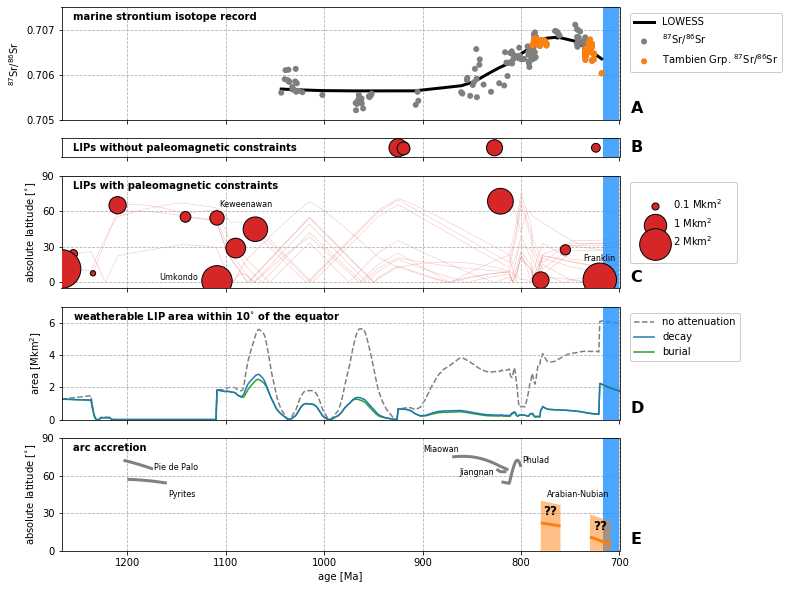

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(10,10), gridspec_kw={'height_ratios':[6,1,6,6,6]})

### Sr data
ax[0].scatter(pre_sturt_composite['age'],pre_sturt_composite['87Sr/86Sr_primary'],
              c='C7', edgecolors='none', label='$^{87}$Sr/$^{86}$Sr', zorder=98)
ax[0].scatter(tambien_data['age'],tambien_data['87Sr/86Sr_primary'],
              c='C1', edgecolors='none', label='Tambien Grp. $^{87}$Sr/$^{86}$Sr', zorder=99)
ax[0].plot(pre_sturt_xy[:,0], pre_sturt_xy[:,1], c='k', lw=3, label='LOWESS')
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].set_ylim(0.705, 0.7075)
ax[0].set_axisbelow(True)
ax[0].grid(ls='--')
ax[0].legend(loc='upper left',bbox_to_anchor=(1.01,0.99),framealpha=1)
ax[0].add_patch(patches.Rectangle((700,0.705),\
                                  717-700,\
                                  0.7075-0.705,\
                                  facecolor='dodgerblue',alpha=0.8, zorder=1))
ax[0].text(1.02,0.1,'A',fontweight='bold',fontsize=16,
           verticalalignment='center',transform=ax[0].transAxes)
ax[0].text(0.02,0.91,'marine strontium isotope record',
           verticalalignment='center',transform=ax[0].transAxes,fontweight='bold')

### unconstrained LIPs

# scale scatter size to area
scatter_size_ratio = 0.0005

scatter_size = unconstrained_LIPs_area*scatter_size_ratio
ax[1].scatter(unconstrained_LIPs_age,[0]*len(unconstrained_LIPs_age),s=scatter_size,facecolor='C3',edgecolor='k')
Gangil_Mayumbia = unconstrained_LIPs[unconstrained_LIPs['name']=='Gangil-Mayumbia'].copy()
Gangil_Mayumbia.reset_index(drop=True,inplace=True)
ax[1].scatter(Gangil_Mayumbia['emplacement_age'][0],0,
              s=Gangil_Mayumbia['emplacement_area_km2'][0]*scatter_size_ratio,facecolor='C3',edgecolor='k')
ax[1].set_ylim(-1,1)
ax[1].set_yticks([])
ax[1].text(0.02,0.5,'LIPs without paleomagnetic constraints',
           verticalalignment='center',transform=ax[1].transAxes,fontweight='bold')
ax[1].text(1.02,0.5,'B',fontweight='bold',fontsize=16,
           verticalalignment='center',transform=ax[1].transAxes)
ax[1].set_axisbelow(True)
ax[1].grid(ls='--')
ax[1].add_patch(patches.Rectangle((700,-1),\
                                  717-700,\
                                  2,\
                                  facecolor='dodgerblue',alpha=0.8, zorder=1))

### constrained LIPs
scatter_size = constrained_LIPs_area*scatter_size_ratio
ax[2].scatter(constrained_LIPs_age,np.abs(constrained_LIPs_lat),
              s=scatter_size,facecolor='C3',edgecolor='k',zorder=99)
ax[2].text(0.02,0.91,'LIPs with paleomagnetic constraints',
           verticalalignment='center',transform=ax[2].transAxes,fontweight='bold')
ax[2].text(1.02,0.1,'C',fontweight='bold',fontsize=16,
           verticalalignment='center',transform=ax[2].transAxes)
ax[2].set_axisbelow(True)
ax[2].grid(ls='--')
ax[2].set_xlim(t_start_emplacement, t_stop_emplacement)
ax[2].set_ylim(-5,90)
ax[2].set_yticks([0,30,60,90])
ax[2].set_ylabel('absolute latitude [$^{\circ}$]')
ax[2].add_patch(patches.Rectangle((700,-5),\
                                  717-700,\
                                  95,\
                                  facecolor='dodgerblue',alpha=0.8, zorder=1))
ax[2].text(0.963,0.27,'Franklin',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[2].transAxes)
ax[2].text(0.210,0.10,'Umkondo',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[2].transAxes)
ax[2].text(0.330,0.75,'Keweenawan',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[2].transAxes)

# constrained LIP centroids
for i in range(len(constrained_LIPs.index)-len(drop_inds)):
    ax[2].plot(ts_emplacement,np.abs(constrained_LIP_centroids[i,:]),
               c='C3',alpha=0.3,zorder=-99,lw=0.5)

# legend creation
l1 = ax[2].scatter([],[], s=100000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l2 = ax[2].scatter([],[], s=1000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
l3 = ax[2].scatter([],[], s=2000000*scatter_size_ratio, facecolor='C3', edgecolor='k')
box = ax[2].get_position()
labels = ['0.1 Mkm$^{2}$', '1 Mkm$^{2}$', '2 Mkm$^{2}$']
ax[2].legend([l1, l2, l3], labels, 
             borderpad=1.5,loc='upper left',bbox_to_anchor=(1.01,0.99),framealpha=1)

### tropical LIPs
ax[3].plot(ts_emplacement, tropical_LIPs/1e6, c='C7', ls='--', label='no attenuation',zorder=0)
ax[3].plot(ts_emplacement, tropical_LIPs_decay/1e6, c='C0', label='decay',zorder=2)
#ax[3].plot(ts_emplacement, tropical_LIPs_weath/1e6, c='C2', label='weathering')
ax[3].plot(ts_emplacement, tropical_LIPs_cover/1e6, c='C2', label='burial',zorder=1)
ax[3].legend(loc='upper left',bbox_to_anchor=(1.01,0.99),framealpha=1)
ax[3].set_ylabel('area [Mkm$^{2}$]')
ax[3].set_axisbelow(True)
ax[3].grid(ls='--')
ax[3].text(0.02,0.91,'weatherable LIP area within 10$^{\circ}$ of the equator',
           verticalalignment='center',transform=ax[3].transAxes,fontweight='bold')
ax[3].text(1.02,0.1,'D',fontweight='bold',fontsize=16,
           verticalalignment='center',transform=ax[3].transAxes)
ax[3].set_ylim(0,7)
ax[3].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  7,\
                                  facecolor='dodgerblue',alpha=0.8, zorder=1))

### arc accretion
ax[4].plot(ANa1_AA_ts, ANa1_AA, c='C1', solid_capstyle='butt', lw=3, label='Arabian-Nubian')
ax[4].plot(ANb1_AA_ts, ANb1_AA, c='C1', solid_capstyle='butt', lw=3, label='__nolegend__')

xy_ANa2 = np.zeros((len(ANa2_AA_max)+2,2))
for i in range(len(ANa2_AA_max)):
    xy_ANa2[i,0] = ANa1_AA_ts[i]
    xy_ANa2[i,1] = ANa2_AA_max[i]
xy_ANa2[-2,0] = ANa1_AA_ts[-1]
xy_ANa2[-1,0] = ANa1_AA_ts[0]
ax[4].add_patch(patches.Polygon(xy_ANa2, facecolor='C1', alpha=0.5, zorder=2))

xy_ANb2 = np.zeros((len(ANb2_AA_max)+2,2))
for i in range(len(ANb2_AA_max)):
    xy_ANb2[i,0] = ANb1_AA_ts[i]
    xy_ANb2[i,1] = ANb2_AA_max[i]
xy_ANb2[-2,0] = ANb1_AA_ts[-1]
xy_ANb2[-1,0] = ANb1_AA_ts[0]
ax[4].add_patch(patches.Polygon(xy_ANb2, facecolor='C1', alpha=0.5, zorder=2))

ax[4].plot(M_AA_ts, M_AA, c='grey', solid_capstyle='butt', lw=3, label='Miaowan')
ax[4].plot(J_AA_ts, J_AA, c='grey', solid_capstyle='butt', lw=3, label='Jiangnan')
ax[4].plot(Py_AA_ts, Py_AA, c='grey', solid_capstyle='butt', lw=3, label='Pyrites')
ax[4].plot(P_AA_ts, P_AA, c='grey', solid_capstyle='butt', lw=3, label='Phulad')
ax[4].plot(PdP_AA_ts, PdP_AA, c='grey', solid_capstyle='butt', lw=3, label='Pie de Palo')
ax[4].set_ylim(0,90)
ax[4].set_yticks([0,30,60,90])
ax[4].text(0.02,0.91,'arc accretion',
           verticalalignment='center',transform=ax[4].transAxes,fontweight='bold')
ax[4].text(1.02,0.1,'E',fontweight='bold',fontsize=16,
           verticalalignment='center',transform=ax[4].transAxes)
ax[4].set_axisbelow(True)
ax[4].grid(ls='--')
ax[4].set_xlabel('age [Ma]')
ax[4].set_ylabel('absolute latitude [$^{\circ}$]')
ax[4].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  90,\
                                  facecolor='dodgerblue',alpha=0.8, zorder=1))
ax[4].text(0.205,0.74,'Pie de Palo',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.215,0.50,'Pyrites',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.680,0.90,'Miaowan',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.745,0.70,'Jiangnan',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.850,0.80,'Phulad',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.925,0.50,'Arabian-Nubian',fontsize=8,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.875,0.35,'??',fontweight='bold',fontsize=12,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)
ax[4].text(0.965,0.22,'??',fontweight='bold',fontsize=12,
           verticalalignment='center',horizontalalignment='center',transform=ax[4].transAxes)

#plt.savefig('../Manuscript/Figures/SrSr_LIPs.pdf', bbox_inches='tight')
plt.show()

## Rb decay

Equations from Vidal (1994) - referenced in Godderis et al. (2017):

In [11]:
def get_MOR_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for MOR.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_MOR = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb * t))
    
    return r_MOR
    
def get_cc_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for continental crust.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_cc = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb*2e9)) +\
                  (0.2783*RbSr_mantle*(9.3485+BABI))*10*(1-np.exp(-lamb*(t-2e9)))
    
    return r_cc

def convert_to_tbp(tsf):
    """
    Convert time since formation (tsf) to time before present (tbp).
    """
    tbp = 4.54e9 - tsf
    return tbp

def convert_to_tsf(tbp):
    """
    Convert tbp to tsf.
    """
    tsf = 4.54e9 - tbp
    return tsf

Plot - to show the evolution.

at 1000Ma, cc  = 0.716048333287914
at 1000Ma, LIP = 0.7023971388988665
###
at 700Ma, cc  = 0.7189556855934848
at 700Ma, LIP = 0.7026797333944707
###
cc difference  = 0.0029073523055708206
LIP difference = 0.0002825944956041937


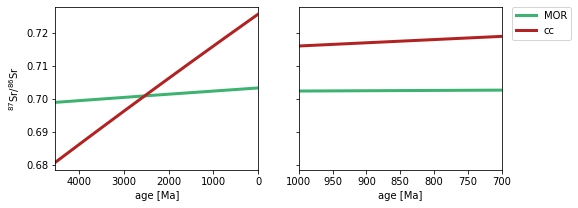

In [12]:
time_evolution = np.linspace(0,4.54e9,500)
MOR_evolution = get_MOR_87Sr86Sr(time_evolution)
cc_evolution = get_cc_87Sr86Sr(time_evolution)

# print some numbers
print('at 1000Ma, cc  = ' + str(get_cc_87Sr86Sr(convert_to_tsf(1000e6))))
print('at 1000Ma, LIP = ' + str(get_MOR_87Sr86Sr(convert_to_tsf(1000e6))))
print('###')
print('at 700Ma, cc  = ' + str(get_cc_87Sr86Sr(convert_to_tsf(700e6))))
print('at 700Ma, LIP = ' + str(get_MOR_87Sr86Sr(convert_to_tsf(700e6))))
print('###')
print('cc difference  = ' + str(get_cc_87Sr86Sr(convert_to_tsf(700e6))-get_cc_87Sr86Sr(convert_to_tsf(1000e6))))
print('LIP difference = ' + str(get_MOR_87Sr86Sr(convert_to_tsf(700e6))-get_MOR_87Sr86Sr(convert_to_tsf(1000e6))))

# convert time to Ma
time_evolution = (time_evolution[::-1])/1e6

fig, ax = plt.subplots(1,2,figsize=(8,3),sharey=True)

ax[0].plot(time_evolution, MOR_evolution, label='MOR', c='mediumseagreen', lw=3)
ax[0].plot(time_evolution, cc_evolution, label='cc', c='firebrick', lw=3)
ax[0].invert_xaxis()
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].set_xlabel('age [Ma]')
ax[0].set_xlim(4540,0)

ax[1].plot(time_evolution, MOR_evolution, label='MOR', c='mediumseagreen', lw=3)
ax[1].plot(time_evolution, cc_evolution, label='cc', c='firebrick', lw=3)
ax[1].invert_xaxis()
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(1000,700)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show(fig)

## Model Functions

* The material values that we will use:
    
| Material           | $^{87}$Sr/$^{86}$Sr | [Mg] (ppm) | [Ca] (ppm) | [Sr] (ppm) |
| :----------------: | :-----------------: | :--------: | :--------: | :--------: |
| continental crust  | n/a                 | 12800      | 23750      | 310        |
| LIP                | 0.7025              | 45500      | 71600      | 465        |
| carbonate          | n/a                 | 47000      | 302300     | 610        |

* The equations:

    (1) $\frac{dMg}{dt} = W_{Mg-carb} + W_{Mg-cc} + W_{Mg-LIP} - H_{Mg-clays} - P_{Mg-carb}$

    (2) $\frac{dCa}{dt} = W_{Ca-carb} + W_{Ca-cc} + W_{Ca-LIP} + H_{Ca-basalt} - P_{Ca-carb}$

    (3) $\frac{d^{n}Sr}{dt} = W_{^{n}Sr-carb} + W_{^{n}Sr-cc} + W_{^{n}Sr-LIP} + H_{^{n}Sr-basalt} - P_{^{n}Sr-carb}$

In [13]:
def seawater_model_v2_2(dt, T, t, Mg, Ca, Sr88, Sr87, Sr86, t_start, ind_vars_i, ind_vars_f):
    """Perform the seawater model version 2.2.
    
    inputs:
    - dt = time step, in years
    - T = model duration, in years
    - t = numpy array containing the time
    - Mg = numpy array containing Mg abundance in mols
    - Ca = numpy array containing Ca abundance in mols
    - Sr88 = numpy array containing Sr88 abundance in mols
    - Sr87 = numpy array containing Sr87 abundance in mols
    - Sr86 = numpy array containing Sr86 abundance in mols
    - t_start = the time (in ybp) of storage vector start
    - ind_vars_i = pandas dataframe of independent variables at the start of the model
    - ind_vars_f = pandas dataframe of independent variables at the end of the model
    
    ouputs:
    - (t,Mg,Ca,Sr88,Sr87,Sr86) = tuple with corresponding numpy arrays
    """
    # length of input vectors
    L = len(t)
    
    # the number of timesteps
    n = int(T / dt)
    
    # create numpy array for each of the independent variables - linearly spaced
    ind_vars = {}
    for i in range(len(ind_vars_i.index)):
        ind_vars[ind_vars_i['var'][i]] = np.linspace(ind_vars_i['val'][i], ind_vars_f['val'][i], n)
        # notify user if variable is evolving
        if ind_vars_i['val'][i] - ind_vars_f['val'][i] != 0:
            print(ind_vars_i['var'][i] + ' changing from ' +\
                  str(ind_vars_i['val'][i]) + ' to ' + str(ind_vars_f['val'][i]))

    # execute model in for loop
    for i in range(L, L+n-1):
        # bulk weathering flux
        W_X_carb = ind_vars['W_X_carb'][i-L]
        W_X_cc = ind_vars['W_X_cc'][i-L]
        W_X_LIP = ind_vars['W_X_LIP'][i-L]
        
        # Mg
        W_Mg_carb = W_X_carb*ind_vars['conc_Mg_carb'][i-L]
        W_Mg_cc = W_X_cc*ind_vars['conc_Mg_cc'][i-L]
        W_Mg_LIP = W_X_LIP*ind_vars['conc_Mg_LIP'][i-L]
        H_Mg_clays = ind_vars['k'][i-L]*(Mg[i-1]/ind_vars['Msw'][i-L])
        dMg = (W_Mg_carb + W_Mg_cc + W_Mg_LIP - H_Mg_clays - ind_vars['P_Mg_carb'][i-L]) * dt
    
        # Ca
        W_Ca_carb = W_X_carb*ind_vars['conc_Ca_carb'][i-L]
        W_Ca_cc = W_X_cc*ind_vars['conc_Ca_cc'][i-L]
        W_Ca_LIP = W_X_LIP*ind_vars['conc_Ca_LIP'][i-L]
        H_Ca_basalt = H_Mg_clays / ind_vars['alpha_MgCa'][i-L]
        P_Ca_carb = W_Mg_carb+W_Mg_cc+W_Mg_LIP-ind_vars['P_Mg_carb'][i-L]+W_Ca_carb+W_Ca_cc+W_Ca_LIP
        dCa = (W_Ca_carb + W_Ca_cc + W_Ca_LIP + H_Ca_basalt - P_Ca_carb) * dt
    
        # total Sr
        W_Sr_carb = W_X_carb*ind_vars['conc_Sr_carb'][i-L]
        W_Sr_cc = W_X_cc*ind_vars['conc_Sr_cc'][i-L]
        W_Sr_LIP = W_X_LIP*ind_vars['conc_Sr_LIP'][i-L]
        H_Sr_basalt = ind_vars['alpha_SrCa'][i-L]*H_Ca_basalt
        P_Sr_carb = ((Sr88[i-1]+Sr87[i-1]+Sr86[i-1])/Ca[i-1])*ind_vars['K_Sr'][i-L]*P_Ca_carb
        
        # precipitating carbonate matches seawater chemistry
        P_87Sr86Sr_carb = Sr87[i-1]/Sr86[i-1]
        
        # W_87Sr86Sr_cc
        W_87Sr86Sr_cc = get_cc_87Sr86Sr(convert_to_tsf(t_start - t[i-1]))
    
        # get 86Sr first
        W_86Sr_carb = W_Sr_carb/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['W_87Sr86Sr_carb'][i-L]+1)
        W_86Sr_cc = W_Sr_cc/((1/ind_vars['r_86Sr88Sr'][i-L])+W_87Sr86Sr_cc+1)
        W_86Sr_LIP = W_Sr_LIP/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['W_87Sr86Sr_LIP'][i-L]+1)
        H_86Sr_basalt = H_Sr_basalt/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['H_87Sr86Sr_basalt'][i-L]+1)
        P_86Sr_carb = P_Sr_carb/((1/ind_vars['r_86Sr88Sr'][i-L])+P_87Sr86Sr_carb+1)
        dSr86 = (W_86Sr_carb + W_86Sr_cc + W_86Sr_LIP + H_86Sr_basalt - P_86Sr_carb) * dt
    
        # use 86Sr to get 88Sr
        dSr88 = dSr86/ind_vars['r_86Sr88Sr'][i-L]
    
        # get 87Sr
        W_87Sr_carb = W_86Sr_carb*ind_vars['W_87Sr86Sr_carb'][i-L]
        W_87Sr_cc = W_86Sr_cc*W_87Sr86Sr_cc
        W_87Sr_LIP = W_86Sr_LIP*ind_vars['W_87Sr86Sr_LIP'][i-L]
        H_87Sr_basalt = H_86Sr_basalt*ind_vars['H_87Sr86Sr_basalt'][i-L]
        P_87Sr_carb = P_86Sr_carb * P_87Sr86Sr_carb
        dSr87 = (W_87Sr_carb + W_87Sr_cc + W_87Sr_LIP + H_87Sr_basalt - P_87Sr_carb) * dt
    
        # store results
        Mg = np.append(Mg, Mg[i-1]+dMg)
        Ca = np.append(Ca, Ca[i-1]+dCa)
        Sr86 = np.append(Sr86, Sr86[i-1]+dSr86)
        Sr88 = np.append(Sr88, Sr88[i-1]+dSr88)
        Sr87 = np.append(Sr87, Sr87[i-1]+dSr87)
        t = np.append(t, t[i-1]+dt)
    
    return (t,Mg,Ca,Sr88,Sr87,Sr86) 

* Mg/Ca = 10 $\pm$ 3

    * Spear et al. (2014)

* $^{87}$Sr/$^{86}$Sr = 0.7055 at 860Ma

    * our data
    
* $^{87}$Sr/$^{86}$Sr = 0.70475 between ~2-1Ga

    * Shields et Veizer (2002)

A function to pre-determine the initial steady state Mg/Ca (for any given set of independent variables).

In [14]:
def get_initial_Mg_Ca(r_MgCa, ind_vars):
    """Calculate initial Mg and Ca that will produce desired Mg/Ca at steady state.
    
    inputs:
    - r_MgCa = desired Mg/Ca at steady state after initial spin up
    - ind_vars = dictionary of independent variables at the start of the model

    ouputs:
    - Mg_0 = initial Mg composition
    - Ca_0 = initial Ca composition
    """
    # Mg fluxes
    W_Mg_carb = ind_vars['W_X_carb']*ind_vars['conc_Mg_carb']
    W_Mg_cc = ind_vars['W_X_cc']*ind_vars['conc_Mg_cc']
    W_Mg_LIP = ind_vars['W_X_LIP']*ind_vars['conc_Mg_LIP']
    
    # make the initial Mg the steady state value
    Mg_0 = ((W_Mg_carb + W_Mg_cc + W_Mg_LIP - ind_vars['P_Mg_carb']) / ind_vars['k']) * ind_vars['Msw']
    
    # since we are starting Mg at the steady state value, we can simply set the initial Ca to be at the desired ratio
    Ca_0 = Mg_0 / r_MgCa
    
    return (Mg_0, Ca_0)

A function to pre-determine the initial steady state $^{87}$Sr/$^{86}$Sr by fixing the exposed area of carbonate, and varying the ratio of exposed continental crust to LIP.

In [15]:
def get_initial_parameters(r_MgCa, r_87Sr86Sr, Sr_0, W_X_carb, W_X_LIP, W_X_cc_min, W_X_cc_max, t_start, ind_vars, n):
    """Calculate initial parameters that will produce desired Mg/Ca and 87Sr/86Sr ratios at steady state.
    
    inputs:
    - r_MgCa = desired Mg/Ca at steady state after initial spin up
    - r_87Sr86Sr = desired 87Sr/86Sr at steady state after initial spin up
    - Sr_0 = initial Sr
    - W_X_carb
    - W_X_LIP
    - W_X_cc_min
    - W_X_cc_max
    - t_start = the time (in ybp) of storage vector start
    - ind_vars = dictionary of independent variables to vary
    - n = number of times to run the loop
    
    ouputs:
    - (Mg_0, Ca_0, W_X_cc) = tuple with initial Mg, Ca, W_X_cc
    
    dependencies:
    - dict_to_sorted_df()
    - get_initial_Mg_Ca()
    """
    dt = 0.1e6
    T = 500e6 #assume we will be in steady state by 100e6 yrs
    Sr88_0 = 0.82 * Sr_0 #approximate ratios
    Sr87_0 = 0.073 * Sr_0
    Sr86_0 = 0.107 * Sr_0
    
    # ratios to test
    W_X_ccs = np.linspace(W_X_cc_min, W_X_cc_max, n)
    
    # storage vectors
    Mg_0_vals = np.array([])
    Ca_0_vals = np.array([])
    Sr87Sr86_ss = np.array([])
    
    for i in range(n):
        # change the ratio
        ind_vars_copy = ind_vars.copy()
        ind_vars_copy['W_X_carb'] = W_X_carb
        ind_vars_copy['W_X_cc'] = W_X_ccs[i]
        ind_vars_copy['W_X_LIP'] = W_X_LIP
        
        # get the initial Mg and Ca that will give the desired Mg/Ca ratio
        (Mg_0_temp, Ca_0_temp) = get_initial_Mg_Ca(r_MgCa, ind_vars_copy)
        Mg_0_vals = np.append(Mg_0_vals, Mg_0_temp)
        Ca_0_vals = np.append(Ca_0_vals, Ca_0_temp)
        
        # convert dictionary to dataframe
        ind_vars_copy_df = dict_to_sorted_df(ind_vars_copy)
        
        # use this initial Ca to determine what the steady state 87Sr/86Sr is
        t = np.array([0])
        Mg = np.array([Mg_0_temp])
        Ca = np.array([Ca_0_temp])
        Sr88 = np.array([Sr88_0])
        Sr87 = np.array([Sr87_0])
        Sr86 = np.array([Sr86_0])
        (t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_copy_df,ind_vars_copy_df)
        Sr87Sr86_ss = np.append(Sr87Sr86_ss, (Sr87[-1]/Sr86[-1]))

    # find the values that give the closest match to the desired 87Sr/86Sr at steady state
    diff = np.array([])
    for i in range(n):
        diff = np.append(diff, abs(Sr87Sr86_ss[i] - r_87Sr86Sr))
    min_ind = diff.argmin()
    Mg_0 = Mg_0_vals[min_ind]
    Ca_0 = Ca_0_vals[min_ind]
    W_X_cc = W_X_ccs[min_ind]
    
    # plot
    fig, ax = plt.subplots()
    ax.plot(W_X_ccs,Sr87Sr86_ss, color='b', linewidth=3)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.hlines(r_87Sr86Sr, W_X_cc_min, W_X_cc_max, color='r', linewidth=3, linestyle='--')
    ax.set_xlabel('input W_X_cc')
    ax.set_ylabel('steady state $^{87}$Sr/$^{86}$Sr')
    ax.set_xlim(W_X_cc_min,W_X_cc_max)
    plt.show(fig)
    
    # print the solutions and deviation away from the desired value
    print('Mg_0 =    ' + str(Mg_0))
    print('Ca_0 =    ' + str(Ca_0))
    print('W_X_cc =  ' + str(W_X_cc))
    print('###')
    print('Desired ratio was: ' + str(r_87Sr86Sr))
    print('Obtained ratio is: ' + str(Sr87Sr86_ss[min_ind]))
    print('Difference is:     ' + str(diff[min_ind]))
    
    return (Mg_0, Ca_0, W_X_cc)

## Model 1

Stage 1: Keep hydrothermal flux constant, change weathering fluxes.

Stage 2: Keep hydrothermal flux constant, change weathering fluxes.

### Initialize the Model

In [16]:
ind_vars_1 = {'W_X_carb':2.184e11,
              'W_X_cc':7.003e11,
              'W_X_LIP':1.423e12,
              'conc_Mg_cc':12800 * (1e-6/0.024305),    #ppm to mol/kg
              'conc_Ca_cc':23750 * (1e-6/0.040078),    #ppm to mol/kg
              'conc_Sr_cc':310 * (1e-6/0.08762),       #ppm to mol/kg
              'conc_Mg_LIP':45500 * (1e-6/0.024305),   #ppm to mol/kg
              'conc_Ca_LIP':71600 * (1e-6/0.040078),   #ppm to mol/kg
              'conc_Sr_LIP':465 * (1e-6/0.08762),      #ppm to mol/kg
              'conc_Mg_carb':47000 * (1e-6/0.024305),  #ppm to mol/kg
              'conc_Ca_carb':302300 * (1e-6/0.040078), #ppm to mol/kg
              'conc_Sr_carb':610 * (1e-6/0.08762),     #ppm to mol/kg
              'alpha_MgCa':1,
              'alpha_SrCa':0.0013,
              'k':3.75e13,                             #kg(H2O)/yr
              'P_Mg_carb':1.8e12,                      #mol/yr
              'K_Sr':0.2,
              'W_87Sr86Sr_LIP':0.7025,
              'W_87Sr86Sr_carb':0.70475,
              'H_87Sr86Sr_basalt':0.7025,
              'r_86Sr88Sr':0.1194,
              'Msw':1.37e21}                           #kg

Get initial parameters.

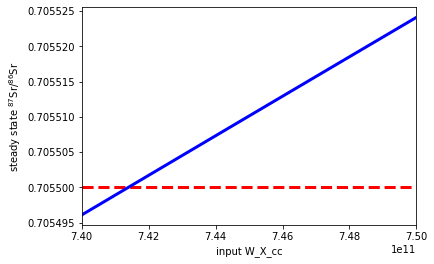

Mg_0 =    6.125892276876104e+19
Ca_0 =    6.125892276876104e+18
W_X_cc =  741578947368.421
###
Desired ratio was: 0.7055
Obtained ratio is: 0.705500528148723
Difference is:     5.281487229780168e-07


In [17]:
Sr_ppm = 100
mm_Sr = 87.62 #molar mass of Sr
Sr_0 = Sr_ppm*(1e-6/0.08762)*ind_vars_1['Msw']
t_start = 1380e6

(Mg_0,Ca_0,W_X_cc) = get_initial_parameters(10,0.7055,Sr_0,ind_vars_1['W_X_carb'],ind_vars_1['W_X_LIP'],\
                                            7.4e11,7.5e11,t_start,ind_vars_1,20)

Use the initial parameters and run to steady state.

In [18]:
dt = 0.1e6
T_ss = 500e6

ind_vars_2 = ind_vars_1.copy()
ind_vars_2['W_X_cc'] = W_X_cc
ind_vars_2_df = dict_to_sorted_df(ind_vars_2)

Sr88_0 = 0.82 * Sr_0 #approximate ratios
Sr87_0 = 0.073 * Sr_0
Sr86_0 = 0.107 * Sr_0

t = np.array([0])
Mg = np.array([Mg_0])
Ca = np.array([Ca_0])
Sr88 = np.array([Sr88_0])
Sr87 = np.array([Sr87_0])
Sr86 = np.array([Sr86_0])

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_ss,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_2_df)

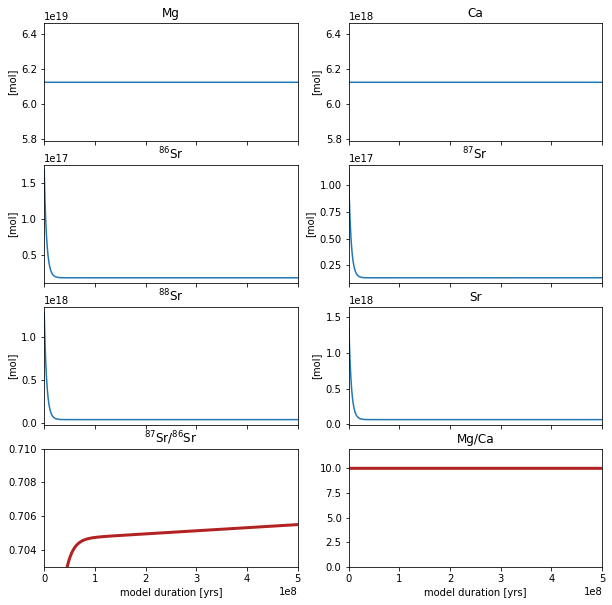

In [19]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss)

### 880-770 Ma

In [20]:
# model duration
T_stage1 = 110e6
axvlines = [(t_start-T_ss)/(1e6)]

total_W_MgCa_sil = ind_vars_2['W_X_cc']*(ind_vars_2['conc_Mg_cc']+ind_vars_2['conc_Ca_cc']) +\
                   ind_vars_2['W_X_LIP']*(ind_vars_2['conc_Mg_LIP']+ind_vars_2['conc_Ca_LIP'])

ind_vars_3 = ind_vars_2.copy()
ind_vars_3['W_X_cc'] = ind_vars_2['W_X_cc'] * 1.57
ind_vars_3['W_X_carb'] = ind_vars_2['W_X_carb'] * 1.57
ind_vars_3['W_X_LIP'] = (total_W_MgCa_sil - ind_vars_3['W_X_cc']*(ind_vars_3['conc_Mg_cc']+ind_vars_3['conc_Ca_cc']))/\
                        (ind_vars_3['conc_Mg_LIP']+ind_vars_3['conc_Ca_LIP'])
ind_vars_3_df = dict_to_sorted_df(ind_vars_3)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage1,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_3_df)

W_X_LIP changing from 1423000000000.0 to 1293686616005.6702
W_X_carb changing from 218400000000.0 to 342888000000.0
W_X_cc changing from 741578947368.421 to 1164278947368.4211


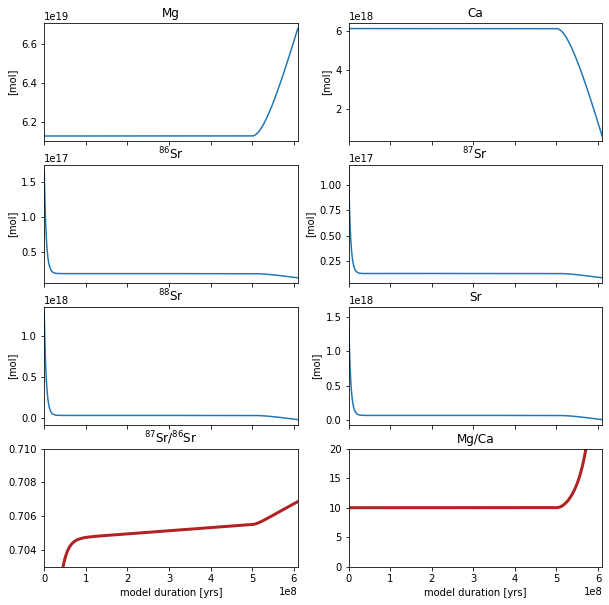

In [21]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,20,0,T_ss+T_stage1)

/Users/yuempark/GitHub/2018_Tambien_Group/Code/Global_Weathering_Model/Seawater_Model_Functions.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if data.loc[i,'label'] not in labels:


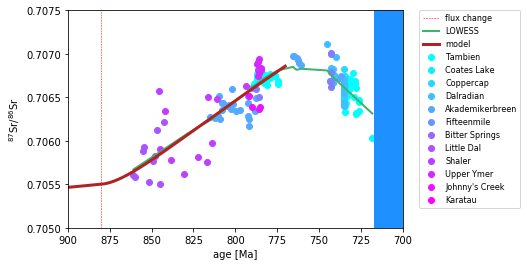

In [22]:
plot_model_and_data(tonian_composite, t, Sr87, Sr86, xy, t_start, axvlines, 0.705, 0.7075, 900, 700)

### 770-717 Ma

In [23]:
# model duration
T_stage2 = 53e6
axvlines.append(axvlines[0]-(T_stage1/1e6))

ind_vars_4 = ind_vars_3.copy()
ind_vars_4['W_X_cc'] = ind_vars_3['W_X_cc'] * 0.71
ind_vars_4['W_X_carb'] = ind_vars_3['W_X_carb'] * 0.71
ind_vars_4['W_X_LIP'] = (total_W_MgCa_sil - ind_vars_4['W_X_cc']*(ind_vars_4['conc_Mg_cc']+ind_vars_4['conc_Ca_cc']))/\
                        (ind_vars_4['conc_Mg_LIP']+ind_vars_4['conc_Ca_LIP'])
ind_vars_4_df = dict_to_sorted_df(ind_vars_4)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage2,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_3_df,ind_vars_4_df)

W_X_LIP changing from 1293686616005.6702 to 1396978517290.9656
W_X_carb changing from 342888000000.0 to 243450480000.0
W_X_cc changing from 1164278947368.4211 to 826638052631.579


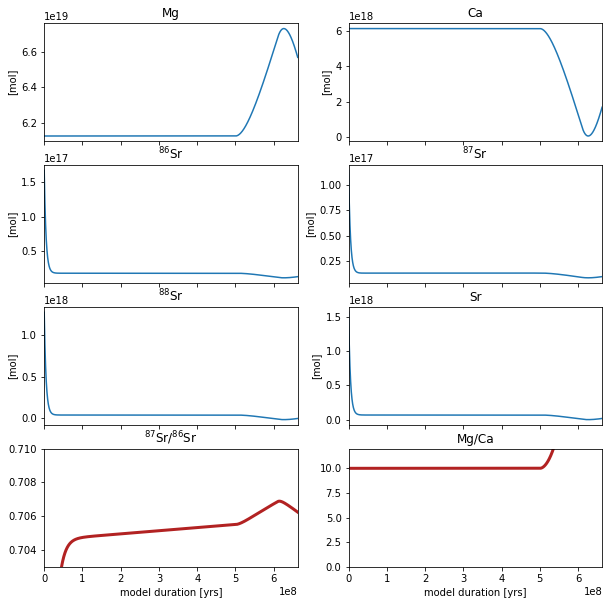

In [24]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss+T_stage1+T_stage2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


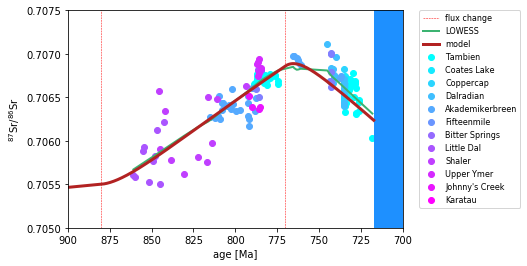

In [25]:
min8786 = 0.705
max8786 = 0.7075
maxt = 900
mint = 700
data = tonian_composite

# shift the time vector, and convert it into Ma
t = t * -1
t = t + t_start
t = t / 1e6

# pull out the labels
labels = np.array([])
for i in range(len(data.index)):
    if data.loc[i,'label'] not in labels:
        labels = np.append(labels, data.loc[i,'label'])

# generate colors
color_idx = np.linspace(0, 1, len(labels))

# plot
fig, ax = plt.subplots()
# the measured data
for i in range(len(labels)):
    ax.scatter(data[data['label']==labels[i]]['age'],data[data['label']==labels[i]]['87Sr/86Sr_primary'],\
               label=labels[i],color=plt.cm.cool(color_idx[i]))
# the axvlines
for i in range(len(axvlines)):
    if i==0:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5, label='flux change')
    else:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5)
# the LOWESS fit
ax.plot(xy[:,0], xy[:,1], label='LOWESS', color='mediumseagreen', lw=2)
# the model output
ax.plot(t,Sr87/Sr86,label='model',color='firebrick',lw=3)
# the glacial
ax.add_patch(patches.Rectangle((mint,min8786),\
                               717-mint,\
                               max8786-min8786,\
                               facecolor='dodgerblue'))
ax.set_xlim([mint,maxt])
ax.set_ylim([min8786,max8786])
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.invert_xaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=8)

plt.show(fig)

### Summary

In [26]:
# steady state
W_Sr_cc = np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      T_ss/dt)
W_Sr_LIP = np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       T_ss/dt)
W_Sr_carb = np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        T_ss/dt)
k = np.linspace(ind_vars_2['k'], ind_vars_2['k'], T_ss/dt)

# add stage 1
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                      ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      (T_stage1/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                                       ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       (T_stage1/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                                        ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        (T_stage1/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_2['k'], ind_vars_3['k'], (T_stage1/dt)-1)))

# add stage 2
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      ind_vars_4['W_X_cc']*ind_vars_4['conc_Sr_cc'],\
                                      (T_stage2/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       ind_vars_4['W_X_LIP']*ind_vars_4['conc_Sr_LIP'],\
                                       (T_stage2/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        ind_vars_4['W_X_carb']*ind_vars_4['conc_Sr_carb'],\
                                        (T_stage2/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_3['k'], ind_vars_4['k'], (T_stage2/dt)-1)))

# H_Sr_basalt - assuming alpha_SrCa, Msw, alpha_MgCa are invariant
H_Sr_basalt = ind_vars_2['alpha_SrCa']*((k*(Mg/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.7/site-package

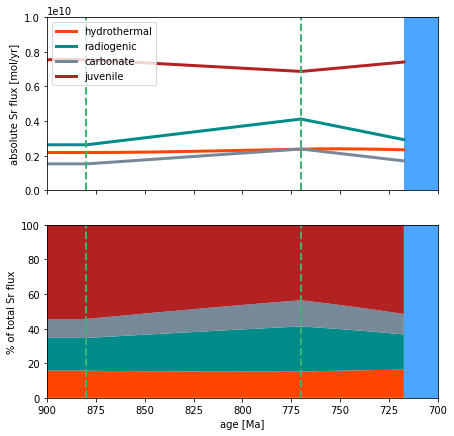

In [27]:
total_Sr_flux = H_Sr_basalt + W_Sr_carb + W_Sr_cc + W_Sr_LIP

fig, ax = plt.subplots(2,1,sharex=True,figsize=(7,7))

### ABSOLUTE FLUXES

ax[0].plot(t, H_Sr_basalt, label='hydrothermal', c='orangered', lw=3)
ax[0].plot(t, W_Sr_cc, label='radiogenic', c='darkcyan', lw=3)
ax[0].plot(t, W_Sr_carb, label='carbonate', c='lightslategrey', lw=3)
ax[0].plot(t, W_Sr_LIP, label='juvenile', c='firebrick', lw=3)

# the axvlines
for i in range(len(axvlines)):
    ax[0].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[0].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  2.5e10,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[0].set_ylim(0,1e10)
ax[0].set_ylabel('absolute Sr flux [mol/yr]')
ax[0].legend(loc=2)
    
### RELATIVE FLUXES

ax[1].stackplot(t,H_Sr_basalt/total_Sr_flux*100,W_Sr_cc/total_Sr_flux*100,W_Sr_carb/total_Sr_flux*100,W_Sr_LIP/total_Sr_flux*100,\
                labels=['hydrothermal','radiogenic','carbonate','juvenile'],\
                colors=['orangered','darkcyan','lightslategrey','firebrick'])

# the axvlines
for i in range(len(axvlines)):
    ax[1].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[1].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  100,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[1].set_xlim(900,700)
ax[1].set_ylim(0,100)
ax[1].set_xlabel('age [Ma]')
ax[1].set_ylabel('% of total Sr flux')

plt.show(fig)

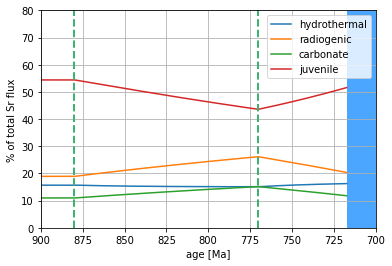

In [28]:
fig, ax = plt.subplots()
ax.plot(t, H_Sr_basalt/total_Sr_flux*100,label='hydrothermal')
ax.plot(t, W_Sr_cc/total_Sr_flux*100,label='radiogenic')
ax.plot(t, W_Sr_carb/total_Sr_flux*100,label='carbonate')
ax.plot(t, W_Sr_LIP/total_Sr_flux*100,label='juvenile')
ax.set_xlim(900,700)
ax.set_ylim(0,80)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('% of total Sr flux')
ax.legend()
for i in range(len(axvlines)):
    ax.axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
ax.add_patch(patches.Rectangle((700,0),\
                               717-700,\
                               100,\
                               facecolor='dodgerblue',alpha=0.8))
ax.grid()
plt.show(fig)

In [29]:
m1_total_Sr_flux = total_Sr_flux
m1_H_Sr_basalt = H_Sr_basalt
m1_W_Sr_cc = W_Sr_cc
m1_W_Sr_carb = W_Sr_carb
m1_W_Sr_LIP = W_Sr_LIP
m1_t = t
m1_Sr87 = Sr87
m1_Sr86 = Sr86
m1_Mg = Mg
m1_Ca = Ca

## Model 2

Stage 1: Keep hydrothermal flux constant, change weathering fluxes.

Stage 2: Change hydrothermal flux, keep weathering fluxes constant.

### Initialize the Model

In [30]:
ind_vars_1 = {'W_X_carb':2.184e11,
              'W_X_cc':7.003e11,
              'W_X_LIP':1.423e12,
              'conc_Mg_cc':12800 * (1e-6/0.024305),    #ppm to mol/kg
              'conc_Ca_cc':23750 * (1e-6/0.040078),    #ppm to mol/kg
              'conc_Sr_cc':310 * (1e-6/0.08762),       #ppm to mol/kg
              'conc_Mg_LIP':45500 * (1e-6/0.024305),   #ppm to mol/kg
              'conc_Ca_LIP':71600 * (1e-6/0.040078),   #ppm to mol/kg
              'conc_Sr_LIP':465 * (1e-6/0.08762),      #ppm to mol/kg
              'conc_Mg_carb':47000 * (1e-6/0.024305),  #ppm to mol/kg
              'conc_Ca_carb':302300 * (1e-6/0.040078), #ppm to mol/kg
              'conc_Sr_carb':610 * (1e-6/0.08762),     #ppm to mol/kg
              'alpha_MgCa':1,
              'alpha_SrCa':0.0013,
              'k':3.75e13,                             #kg(H2O)/yr
              'P_Mg_carb':1.8e12,                      #mol/yr
              'K_Sr':0.2,
              'W_87Sr86Sr_LIP':0.7025,
              'W_87Sr86Sr_carb':0.70475,
              'H_87Sr86Sr_basalt':0.7025,
              'r_86Sr88Sr':0.1194,
              'Msw':1.37e21}                           #kg

Get initial parameters.

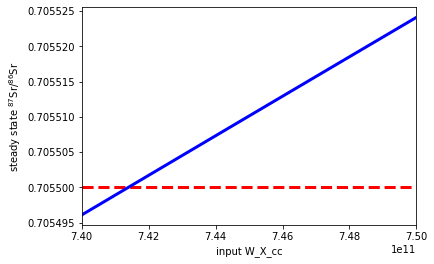

Mg_0 =    6.125892276876104e+19
Ca_0 =    6.125892276876104e+18
W_X_cc =  741578947368.421
###
Desired ratio was: 0.7055
Obtained ratio is: 0.705500528148723
Difference is:     5.281487229780168e-07


In [31]:
Sr_ppm = 100
mm_Sr = 87.62 #molar mass of Sr
Sr_0 = Sr_ppm*(1e-6/0.08762)*ind_vars_1['Msw']
t_start = 1380e6

(Mg_0,Ca_0,W_X_cc) = get_initial_parameters(10,0.7055,Sr_0,ind_vars_1['W_X_carb'],ind_vars_1['W_X_LIP'],\
                                            7.4e11,7.5e11,t_start,ind_vars_1,20)

Use the initial parameters and run to steady state.

In [32]:
dt = 0.1e6
T_ss = 500e6

ind_vars_2 = ind_vars_1.copy()
ind_vars_2['W_X_cc'] = W_X_cc
ind_vars_2_df = dict_to_sorted_df(ind_vars_2)

Sr88_0 = 0.82 * Sr_0 #approximate ratios
Sr87_0 = 0.073 * Sr_0
Sr86_0 = 0.107 * Sr_0

t = np.array([0])
Mg = np.array([Mg_0])
Ca = np.array([Ca_0])
Sr88 = np.array([Sr88_0])
Sr87 = np.array([Sr87_0])
Sr86 = np.array([Sr86_0])

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_ss,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_2_df)

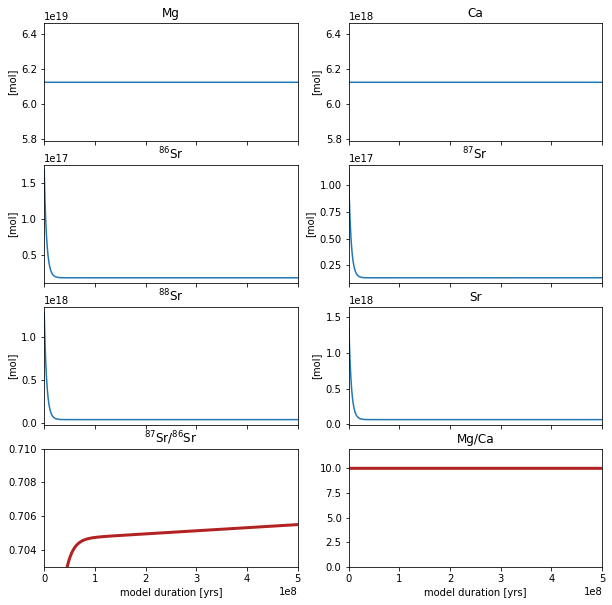

In [33]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss)

### 880-770 Ma

In [34]:
# model duration
T_stage1 = 110e6
axvlines = [(t_start-T_ss)/(1e6)]

total_W_MgCa_sil = ind_vars_2['W_X_cc']*(ind_vars_2['conc_Mg_cc']+ind_vars_2['conc_Ca_cc']) +\
                   ind_vars_2['W_X_LIP']*(ind_vars_2['conc_Mg_LIP']+ind_vars_2['conc_Ca_LIP'])

ind_vars_3 = ind_vars_2.copy()
ind_vars_3['W_X_cc'] = ind_vars_2['W_X_cc'] * 1.57
ind_vars_3['W_X_carb'] = ind_vars_2['W_X_carb'] * 1.57
ind_vars_3['W_X_LIP'] = (total_W_MgCa_sil - ind_vars_3['W_X_cc']*(ind_vars_3['conc_Mg_cc']+ind_vars_3['conc_Ca_cc']))/\
                        (ind_vars_3['conc_Mg_LIP']+ind_vars_3['conc_Ca_LIP'])
ind_vars_3_df = dict_to_sorted_df(ind_vars_3)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage1,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_3_df)

W_X_LIP changing from 1423000000000.0 to 1293686616005.6702
W_X_carb changing from 218400000000.0 to 342888000000.0
W_X_cc changing from 741578947368.421 to 1164278947368.4211


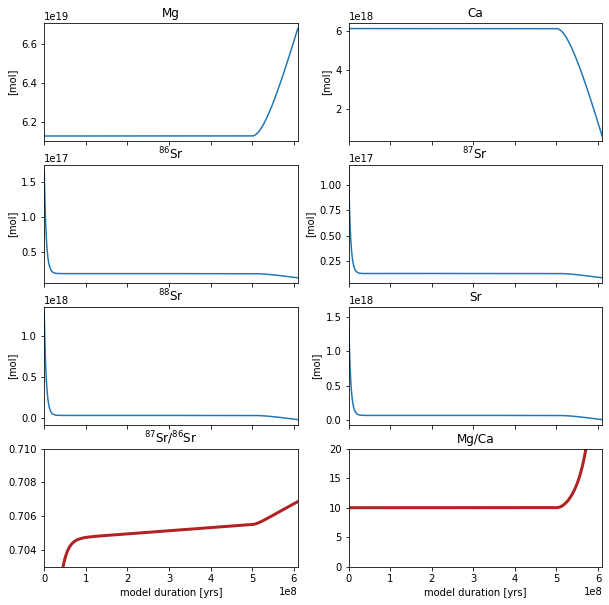

In [35]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,20,0,T_ss+T_stage1)

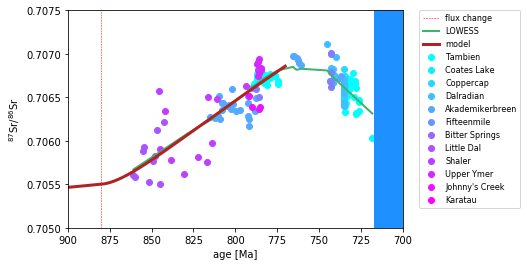

In [36]:
plot_model_and_data(tonian_composite, t, Sr87, Sr86, xy, t_start, axvlines, 0.705, 0.7075, 900, 700)

### 770-717 Ma

In [37]:
# model duration
T_stage2 = 53e6
axvlines.append(axvlines[0]-(T_stage1/1e6))

ind_vars_4 = ind_vars_3.copy()
ind_vars_4['k'] = ind_vars_3['k'] * 4
ind_vars_4_df = dict_to_sorted_df(ind_vars_4)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage2,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_3_df,ind_vars_4_df)

k changing from 37500000000000.0 to 150000000000000.0


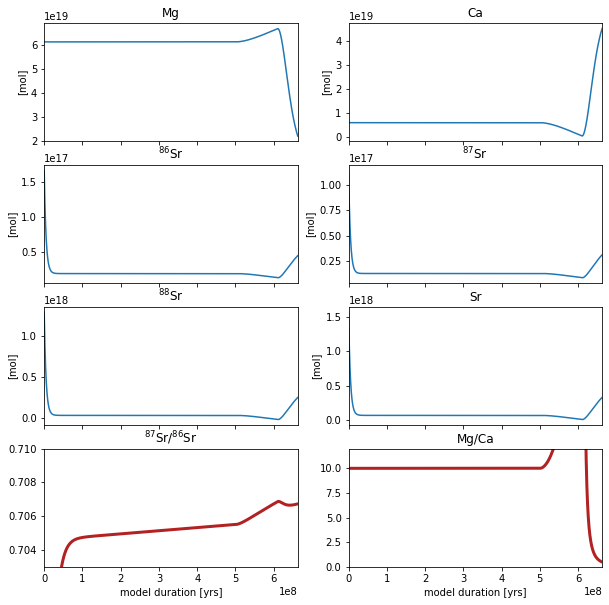

In [38]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss+T_stage1+T_stage2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


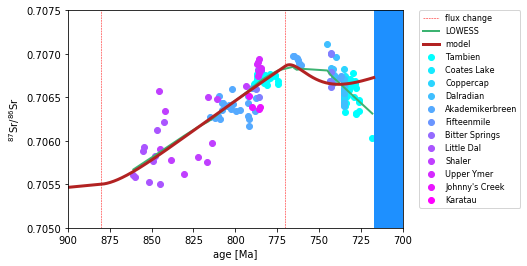

In [39]:
min8786 = 0.705
max8786 = 0.7075
maxt = 900
mint = 700
data = tonian_composite

# shift the time vector, and convert it into Ma
t = t * -1
t = t + t_start
t = t / 1e6

# pull out the labels
labels = np.array([])
for i in range(len(data.index)):
    if data.loc[i,'label'] not in labels:
        labels = np.append(labels, data.loc[i,'label'])

# generate colors
color_idx = np.linspace(0, 1, len(labels))

# plot
fig, ax = plt.subplots()
# the measured data
for i in range(len(labels)):
    ax.scatter(data[data['label']==labels[i]]['age'],data[data['label']==labels[i]]['87Sr/86Sr_primary'],\
               label=labels[i],color=plt.cm.cool(color_idx[i]))
# the axvlines
for i in range(len(axvlines)):
    if i==0:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5, label='flux change')
    else:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5)
# the LOWESS fit
ax.plot(xy[:,0], xy[:,1], label='LOWESS', color='mediumseagreen', lw=2)
# the model output
ax.plot(t,Sr87/Sr86,label='model',color='firebrick',lw=3)
# the glacial
ax.add_patch(patches.Rectangle((mint,min8786),\
                               717-mint,\
                               max8786-min8786,\
                               facecolor='dodgerblue'))
ax.set_xlim([mint,maxt])
ax.set_ylim([min8786,max8786])
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.invert_xaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=8)

plt.show(fig)

### Summary

In [40]:
# steady state
W_Sr_cc = np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      T_ss/dt)
W_Sr_LIP = np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       T_ss/dt)
W_Sr_carb = np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        T_ss/dt)
k = np.linspace(ind_vars_2['k'], ind_vars_2['k'], T_ss/dt)

# add stage 1
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                      ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      (T_stage1/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                                       ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       (T_stage1/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                                        ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        (T_stage1/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_2['k'], ind_vars_3['k'], (T_stage1/dt)-1)))

# add stage 2
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      ind_vars_4['W_X_cc']*ind_vars_4['conc_Sr_cc'],\
                                      (T_stage2/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       ind_vars_4['W_X_LIP']*ind_vars_4['conc_Sr_LIP'],\
                                       (T_stage2/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        ind_vars_4['W_X_carb']*ind_vars_4['conc_Sr_carb'],\
                                        (T_stage2/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_3['k'], ind_vars_4['k'], (T_stage2/dt)-1)))

# H_Sr_basalt - assuming alpha_SrCa, Msw, alpha_MgCa are invariant
H_Sr_basalt = ind_vars_2['alpha_SrCa']*((k*(Mg/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.7/site-package

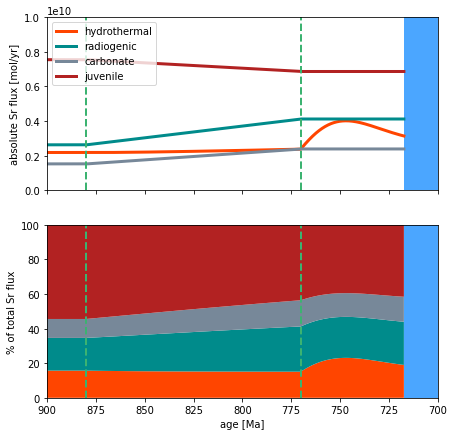

In [41]:
total_Sr_flux = H_Sr_basalt + W_Sr_carb + W_Sr_cc + W_Sr_LIP

fig, ax = plt.subplots(2,1,sharex=True,figsize=(7,7))

### ABSOLUTE FLUXES

ax[0].plot(t, H_Sr_basalt, label='hydrothermal', c='orangered', lw=3)
ax[0].plot(t, W_Sr_cc, label='radiogenic', c='darkcyan', lw=3)
ax[0].plot(t, W_Sr_carb, label='carbonate', c='lightslategrey', lw=3)
ax[0].plot(t, W_Sr_LIP, label='juvenile', c='firebrick', lw=3)

# the axvlines
for i in range(len(axvlines)):
    ax[0].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[0].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  2.5e10,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[0].set_ylim(0,1e10)
ax[0].set_ylabel('absolute Sr flux [mol/yr]')
ax[0].legend(loc=2)
    
### RELATIVE FLUXES

ax[1].stackplot(t,H_Sr_basalt/total_Sr_flux*100,W_Sr_cc/total_Sr_flux*100,W_Sr_carb/total_Sr_flux*100,W_Sr_LIP/total_Sr_flux*100,\
                labels=['hydrothermal','radiogenic','carbonate','juvenile'],\
                colors=['orangered','darkcyan','lightslategrey','firebrick'])

# the axvlines
for i in range(len(axvlines)):
    ax[1].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[1].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  100,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[1].set_xlim(900,700)
ax[1].set_ylim(0,100)
ax[1].set_xlabel('age [Ma]')
ax[1].set_ylabel('% of total Sr flux')

plt.show(fig)

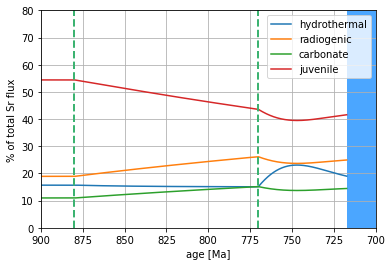

In [42]:
fig, ax = plt.subplots()
ax.plot(t, H_Sr_basalt/total_Sr_flux*100,label='hydrothermal')
ax.plot(t, W_Sr_cc/total_Sr_flux*100,label='radiogenic')
ax.plot(t, W_Sr_carb/total_Sr_flux*100,label='carbonate')
ax.plot(t, W_Sr_LIP/total_Sr_flux*100,label='juvenile')
ax.set_xlim(900,700)
ax.set_ylim(0,80)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('% of total Sr flux')
ax.legend()
for i in range(len(axvlines)):
    ax.axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
ax.add_patch(patches.Rectangle((700,0),\
                               717-700,\
                               100,\
                               facecolor='dodgerblue',alpha=0.8))
ax.grid()
plt.show(fig)

In [43]:
m2_total_Sr_flux = total_Sr_flux
m2_H_Sr_basalt = H_Sr_basalt
m2_W_Sr_cc = W_Sr_cc
m2_W_Sr_carb = W_Sr_carb
m2_W_Sr_LIP = W_Sr_LIP
m2_t = t
m2_Sr87 = Sr87
m2_Sr86 = Sr86
m2_Mg = Mg
m2_Ca = Ca

## Model 5

Jack up initial Mg and Ca concentrations.

Stage 1: Keep hydrothermal flux constant, change weathering fluxes.

Stage 2: Change hydrothermal flux, keep weathering fluxes constant.

### Initialize the Model

In [44]:
ind_vars_1 = {'W_X_carb':2.184e11 * 1000,
              'W_X_cc':7.003e11 * 1000,
              'W_X_LIP':1.423e12 * 1000,
              'conc_Mg_cc':12800 * (1e-6/0.024305),    #ppm to mol/kg
              'conc_Ca_cc':23750 * (1e-6/0.040078),    #ppm to mol/kg
              'conc_Sr_cc':310 * (1e-6/0.08762),       #ppm to mol/kg
              'conc_Mg_LIP':45500 * (1e-6/0.024305),   #ppm to mol/kg
              'conc_Ca_LIP':71600 * (1e-6/0.040078),   #ppm to mol/kg
              'conc_Sr_LIP':465 * (1e-6/0.08762),      #ppm to mol/kg
              'conc_Mg_carb':47000 * (1e-6/0.024305),  #ppm to mol/kg
              'conc_Ca_carb':302300 * (1e-6/0.040078), #ppm to mol/kg
              'conc_Sr_carb':610 * (1e-6/0.08762),     #ppm to mol/kg
              'alpha_MgCa':1,
              'alpha_SrCa':0.0013,
              'k':3.75e13 / 3,                             #kg(H2O)/yr
              'P_Mg_carb':1.8e12,                      #mol/yr
              'K_Sr':0.2,
              'W_87Sr86Sr_LIP':0.7025,
              'W_87Sr86Sr_carb':0.70475,
              'H_87Sr86Sr_basalt':0.7025,
              'r_86Sr88Sr':0.1194,
              'Msw':1.37e21}                           #kg

Get initial parameters.

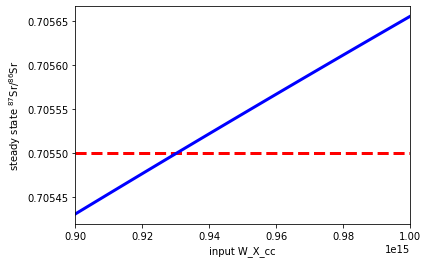

Mg_0 =    3.91826252346604e+23
Ca_0 =    3.91826252346604e+22
W_X_cc =  931578947368421.0
###
Desired ratio was: 0.7055
Obtained ratio is: 0.7055032480980648
Difference is:     3.2480980647342506e-06


In [45]:
Sr_ppm = 100
mm_Sr = 87.62 #molar mass of Sr
Sr_0 = Sr_ppm*(1e-6/0.08762)*ind_vars_1['Msw']
t_start = 1380e6

(Mg_0,Ca_0,W_X_cc) = get_initial_parameters(10,0.7055,Sr_0,ind_vars_1['W_X_carb'],ind_vars_1['W_X_LIP'],\
                                            9e14,10e14,t_start,ind_vars_1,20)

Use the initial parameters and run to steady state.

In [46]:
dt = 0.1e6
T_ss = 500e6

ind_vars_2 = ind_vars_1.copy()
ind_vars_2['W_X_cc'] = W_X_cc
ind_vars_2_df = dict_to_sorted_df(ind_vars_2)

Sr88_0 = 0.82 * Sr_0 #approximate ratios
Sr87_0 = 0.073 * Sr_0
Sr86_0 = 0.107 * Sr_0

t = np.array([0])
Mg = np.array([Mg_0])
Ca = np.array([Ca_0])
Sr88 = np.array([Sr88_0])
Sr87 = np.array([Sr87_0])
Sr86 = np.array([Sr86_0])

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_ss,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_2_df)

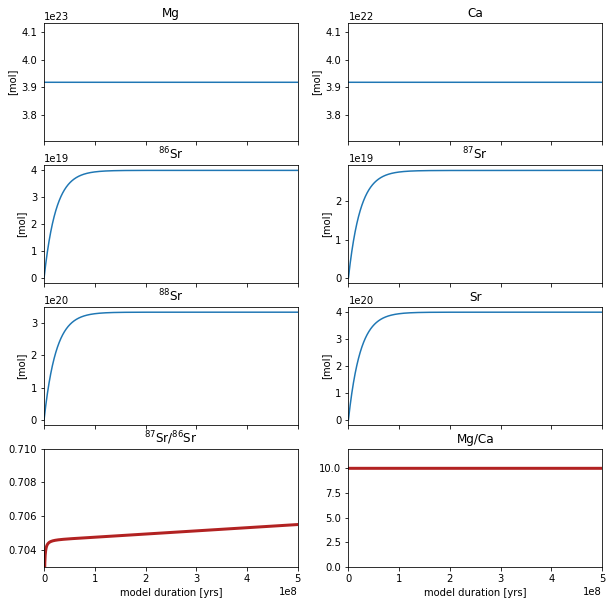

In [47]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss)

### 880-770 Ma

In [48]:
# model duration
T_stage1 = 110e6
axvlines = [(t_start-T_ss)/(1e6)]

total_W_MgCa_sil = ind_vars_2['W_X_cc']*(ind_vars_2['conc_Mg_cc']+ind_vars_2['conc_Ca_cc']) +\
                   ind_vars_2['W_X_LIP']*(ind_vars_2['conc_Mg_LIP']+ind_vars_2['conc_Ca_LIP'])

ind_vars_3 = ind_vars_2.copy()
ind_vars_3['W_X_cc'] = ind_vars_2['W_X_cc'] * 1.65
ind_vars_3['W_X_carb'] = ind_vars_2['W_X_carb'] * 1.65
ind_vars_3['W_X_LIP'] = (total_W_MgCa_sil - ind_vars_3['W_X_cc']*(ind_vars_3['conc_Mg_cc']+ind_vars_3['conc_Ca_cc']))/\
                        (ind_vars_3['conc_Mg_LIP']+ind_vars_3['conc_Ca_LIP'])
ind_vars_3_df = dict_to_sorted_df(ind_vars_3)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage1,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_3_df)

W_X_LIP changing from 1423000000000000.0 to 1237755956961542.8
W_X_carb changing from 218400000000000.0 to 360360000000000.0
W_X_cc changing from 931578947368421.0 to 1537105263157894.5


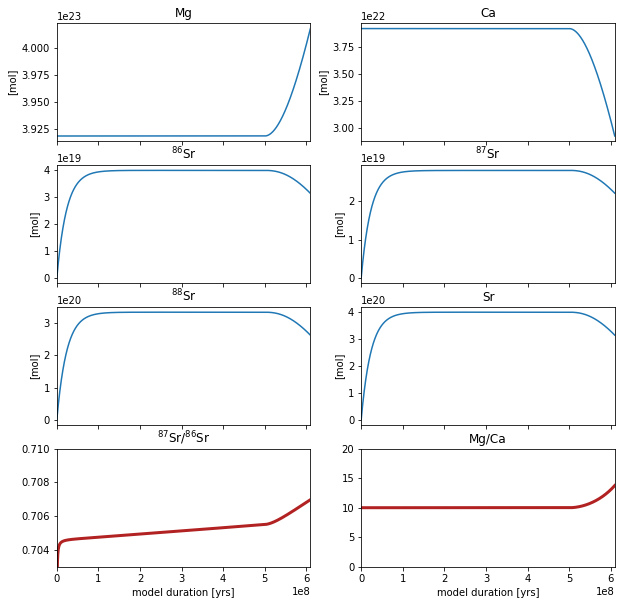

In [49]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,20,0,T_ss+T_stage1)

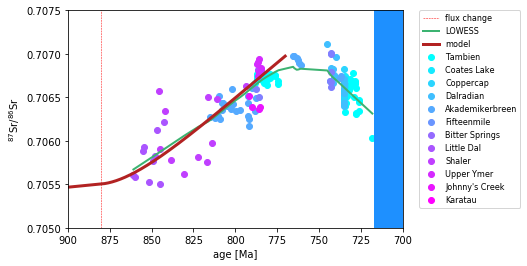

In [50]:
plot_model_and_data(tonian_composite, t, Sr87, Sr86, xy, t_start, axvlines, 0.705, 0.7075, 900, 700)

### 770-717 Ma

In [51]:
# model duration
T_stage2 = 53e6
axvlines.append(axvlines[0]-(T_stage1/1e6))

ind_vars_4 = ind_vars_3.copy()
ind_vars_4['k'] = ind_vars_3['k'] * 4
ind_vars_4_df = dict_to_sorted_df(ind_vars_4)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model_v2_2(dt,T_stage2,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_3_df,ind_vars_4_df)

k changing from 12500000000000.0 to 50000000000000.0


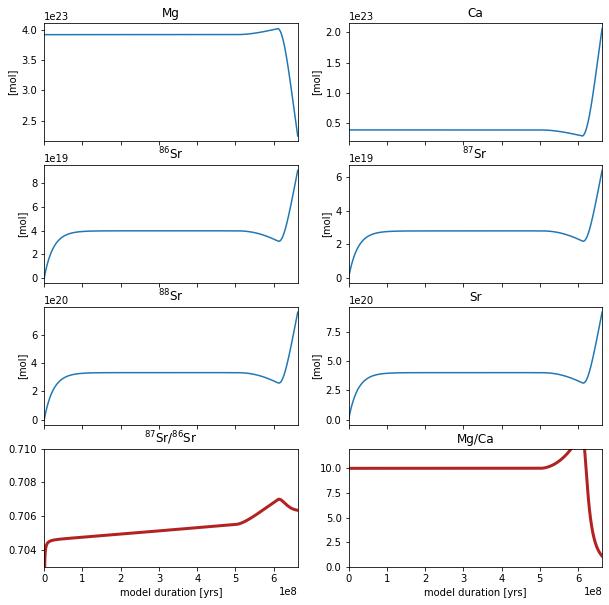

In [52]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss+T_stage1+T_stage2)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  from ipykernel import kernelapp as app


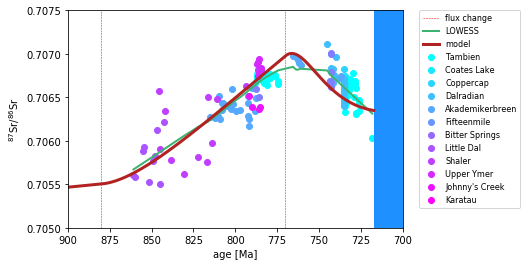

In [53]:
min8786 = 0.705
max8786 = 0.7075
maxt = 900
mint = 700
data = tonian_composite

# shift the time vector, and convert it into Ma
t = t * -1
t = t + t_start
t = t / 1e6

# pull out the labels
labels = np.array([])
for i in range(len(data.index)):
    if data.loc[i,'label'] not in labels:
        labels = np.append(labels, data.loc[i,'label'])

# generate colors
color_idx = np.linspace(0, 1, len(labels))

# plot
fig, ax = plt.subplots()
# the measured data
for i in range(len(labels)):
    ax.scatter(data[data['label']==labels[i]]['age'],data[data['label']==labels[i]]['87Sr/86Sr_primary'],\
               label=labels[i],color=plt.cm.cool(color_idx[i]))
# the axvlines
for i in range(len(axvlines)):
    if i==0:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5, label='flux change')
    else:
        ax.axvline(axvlines[i], c='red', ls='--', lw=0.5)
# the LOWESS fit
ax.plot(xy[:,0], xy[:,1], label='LOWESS', color='mediumseagreen', lw=2)
# the model output
ax.plot(t,Sr87/Sr86,label='model',color='firebrick',lw=3)
# the glacial
ax.add_patch(patches.Rectangle((mint,min8786),\
                               717-mint,\
                               max8786-min8786,\
                               facecolor='dodgerblue'))
ax.set_xlim([mint,maxt])
ax.set_ylim([min8786,max8786])
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.invert_xaxis()
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=8)

plt.show(fig)

### Summary

In [54]:
# steady state
W_Sr_cc = np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                      T_ss/dt)
W_Sr_LIP = np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                       T_ss/dt)
W_Sr_carb = np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                        T_ss/dt)
k = np.linspace(ind_vars_2['k'], ind_vars_2['k'], T_ss/dt)

# add stage 1
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                      ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      (T_stage1/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_2['W_X_LIP']*ind_vars_2['conc_Sr_LIP'],\
                                       ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       (T_stage1/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_2['W_X_carb']*ind_vars_2['conc_Sr_carb'],\
                                        ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        (T_stage1/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_2['k'], ind_vars_3['k'], (T_stage1/dt)-1)))

# add stage 2
W_Sr_cc = np.concatenate((W_Sr_cc,\
                          np.linspace(ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                      ind_vars_4['W_X_cc']*ind_vars_4['conc_Sr_cc'],\
                                      (T_stage2/dt)-1)))
W_Sr_LIP = np.concatenate((W_Sr_LIP,\
                           np.linspace(ind_vars_3['W_X_LIP']*ind_vars_3['conc_Sr_LIP'],\
                                       ind_vars_4['W_X_LIP']*ind_vars_4['conc_Sr_LIP'],\
                                       (T_stage2/dt)-1)))
W_Sr_carb = np.concatenate((W_Sr_carb,\
                            np.linspace(ind_vars_3['W_X_carb']*ind_vars_3['conc_Sr_carb'],\
                                        ind_vars_4['W_X_carb']*ind_vars_4['conc_Sr_carb'],\
                                        (T_stage2/dt)-1)))
k = np.concatenate((k,\
                    np.linspace(ind_vars_3['k'], ind_vars_4['k'], (T_stage2/dt)-1)))

# H_Sr_basalt - assuming alpha_SrCa, Msw, alpha_MgCa are invariant
H_Sr_basalt = ind_vars_2['alpha_SrCa']*((k*(Mg/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/anaconda3/lib/python3.7/site-package

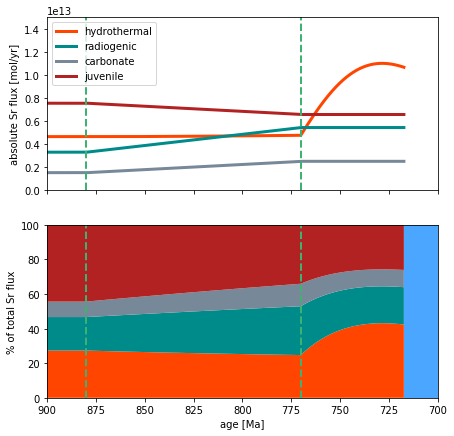

In [55]:
total_Sr_flux = H_Sr_basalt + W_Sr_carb + W_Sr_cc + W_Sr_LIP

fig, ax = plt.subplots(2,1,sharex=True,figsize=(7,7))

### ABSOLUTE FLUXES

ax[0].plot(t, H_Sr_basalt, label='hydrothermal', c='orangered', lw=3)
ax[0].plot(t, W_Sr_cc, label='radiogenic', c='darkcyan', lw=3)
ax[0].plot(t, W_Sr_carb, label='carbonate', c='lightslategrey', lw=3)
ax[0].plot(t, W_Sr_LIP, label='juvenile', c='firebrick', lw=3)

# the axvlines
for i in range(len(axvlines)):
    ax[0].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[0].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  2.5e10,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[0].set_ylim(0,1.5e13)
ax[0].set_ylabel('absolute Sr flux [mol/yr]')
ax[0].legend(loc=2)
    
### RELATIVE FLUXES

ax[1].stackplot(t,H_Sr_basalt/total_Sr_flux*100,W_Sr_cc/total_Sr_flux*100,W_Sr_carb/total_Sr_flux*100,W_Sr_LIP/total_Sr_flux*100,\
                labels=['hydrothermal','radiogenic','carbonate','juvenile'],\
                colors=['orangered','darkcyan','lightslategrey','firebrick'])

# the axvlines
for i in range(len(axvlines)):
    ax[1].axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
    
# the glacial
ax[1].add_patch(patches.Rectangle((700,0),\
                                  717-700,\
                                  100,\
                                  facecolor='dodgerblue',alpha=0.8))
    
ax[1].set_xlim(900,700)
ax[1].set_ylim(0,100)
ax[1].set_xlabel('age [Ma]')
ax[1].set_ylabel('% of total Sr flux')

plt.show(fig)

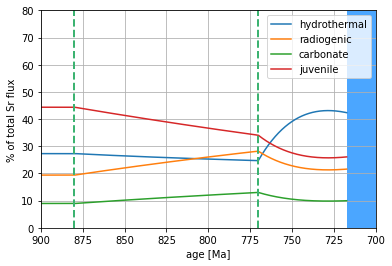

In [56]:
fig, ax = plt.subplots()
ax.plot(t, H_Sr_basalt/total_Sr_flux*100,label='hydrothermal')
ax.plot(t, W_Sr_cc/total_Sr_flux*100,label='radiogenic')
ax.plot(t, W_Sr_carb/total_Sr_flux*100,label='carbonate')
ax.plot(t, W_Sr_LIP/total_Sr_flux*100,label='juvenile')
ax.set_xlim(900,700)
ax.set_ylim(0,80)
ax.set_xlabel('age [Ma]')
ax.set_ylabel('% of total Sr flux')
ax.legend()
for i in range(len(axvlines)):
    ax.axvline(axvlines[i], c='mediumseagreen', ls='--', lw=2)
ax.add_patch(patches.Rectangle((700,0),\
                               717-700,\
                               100,\
                               facecolor='dodgerblue',alpha=0.8))
ax.grid()
plt.show(fig)

In [57]:
m5_total_Sr_flux = total_Sr_flux
m5_H_Sr_basalt = H_Sr_basalt
m5_W_Sr_cc = W_Sr_cc
m5_W_Sr_carb = W_Sr_carb
m5_W_Sr_LIP = W_Sr_LIP
m5_t = t
m5_Sr87 = Sr87
m5_Sr86 = Sr86
m5_Mg = Mg
m5_Ca = Ca

## Summary Plot

This code produces Figure 15 in the main text:

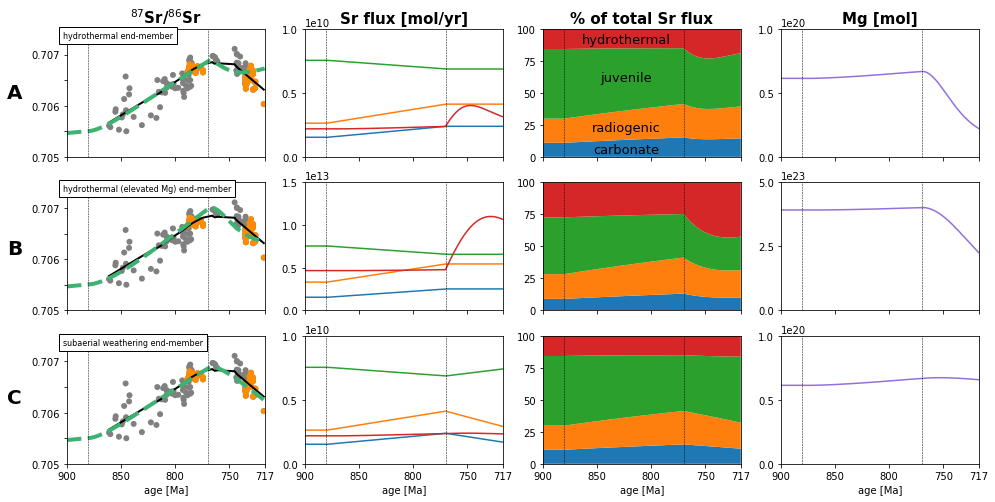

In [58]:
fig, ax = plt.subplots(3,4,sharex='col',figsize=(15,8))

###### 0,0

# data
ax[0][0].scatter(pre_sturt_composite['age'],pre_sturt_composite['87Sr/86Sr_primary'],\
                 c='grey', edgecolors='none')
ax[0][0].scatter(tambien_data['age'],tambien_data['87Sr/86Sr_primary'],\
                 c='darkorange', edgecolors='none')

# LOWESS fit
ax[0][0].plot(xy[:,0], xy[:,1], c='k', lw=2)

# the model output
ax[0][0].plot(t[4800:],(m2_Sr87/m2_Sr86)[4800:],'--',label='model',color='mediumseagreen',lw=4)
ax[0][0].set_ylim(0.705,0.7075)
ax[0][0].set_xlim(900,717)
ax[0][0].set_xticks([900,850,800,750,717])
ax[0][0].axvline(880, color='k', lw=0.5, linestyle='--')
ax[0][0].axvline(770, color='k', lw=0.5, linestyle='--')
ax[0][0].set_yticklabels([0.705,'',0.706,'',0.707,''])
ax[0][0].set_title('$^{87}$Sr/$^{86}$Sr', fontweight='bold', fontsize=15)

###### 1,0

# data
ax[1][0].scatter(pre_sturt_composite['age'],pre_sturt_composite['87Sr/86Sr_primary'],\
                 c='grey', edgecolors='none')
ax[1][0].scatter(tambien_data['age'],tambien_data['87Sr/86Sr_primary'],\
                 c='darkorange', edgecolors='none')

# LOWESS fit
ax[1][0].plot(xy[:,0], xy[:,1], c='k', lw=2)

# the model output
ax[1][0].plot(t[4800:],(m5_Sr87/m5_Sr86)[4800:],'--',label='model',color='mediumseagreen',lw=4)
ax[1][0].axvline(880, color='k', lw=0.5, linestyle='--')
ax[1][0].axvline(770, color='k', lw=0.5, linestyle='--')
ax[1][0].set_ylim(0.705,0.7075)
ax[1][0].set_yticklabels([0.705,'',0.706,'',0.707,''])

###### 2,0

# data
ax[2][0].scatter(pre_sturt_composite['age'],pre_sturt_composite['87Sr/86Sr_primary'],\
                 c='grey', edgecolors='none')
ax[2][0].scatter(tambien_data['age'],tambien_data['87Sr/86Sr_primary'],\
                 c='darkorange', edgecolors='none')

# LOWESS fit
ax[2][0].plot(xy[:,0], xy[:,1], c='k', lw=2)

# the model output
ax[2][0].plot(t[4800:],(m1_Sr87/m1_Sr86)[4800:],'--',label='model',color='mediumseagreen',lw=4)
ax[2][0].axvline(880, color='k', lw=0.5, linestyle='--')
ax[2][0].axvline(770, color='k', lw=0.5, linestyle='--')
ax[2][0].set_ylim(0.705,0.7075)
ax[2][0].set_yticklabels([0.705,'',0.706,'',0.707,''])
ax[2][0].set_xlabel('age [Ma]')

###### 0,1
ax[0][1].plot(t, m2_W_Sr_carb, label='carbonate', color='#1f77b4')
ax[0][1].plot(t, m2_W_Sr_cc, label='radiogenic', color='#ff7f0e')
ax[0][1].plot(t, m2_W_Sr_LIP, label='juvenile', color='#2ca02c')
ax[0][1].plot(t, m2_H_Sr_basalt, label='hydrothermal', color='#d62728')
ax[0][1].set_xlim(900,717)
ax[0][1].set_xticks([900,850,800,750,717])
ax[0][1].set_ylim(0,1.0e10)
ax[0][1].axvline(880, color='k', lw=0.5, linestyle='--')
ax[0][1].axvline(770, color='k', lw=0.5, linestyle='--')
ax[0][1].set_yticks([0,0.5e10,1e10])
ax[0][1].set_title('Sr flux [mol/yr]', fontweight='bold', fontsize=15)

###### 1,1
ax[1][1].plot(t, m5_W_Sr_carb, label='carbonate', color='#1f77b4')
ax[1][1].plot(t, m5_W_Sr_cc, label='radiogenic', color='#ff7f0e')
ax[1][1].plot(t, m5_W_Sr_LIP, label='juvenile', color='#2ca02c')
ax[1][1].plot(t, m5_H_Sr_basalt, label='hydrothermal', color='#d62728')
ax[1][1].axvline(880, color='k', lw=0.5, linestyle='--')
ax[1][1].axvline(770, color='k', lw=0.5, linestyle='--')
ax[1][1].set_ylim(0,1.5e13)
ax[1][1].set_yticks([0,0.5e13,1e13,1.5e13])

###### 2,1
ax[2][1].plot(t, m1_W_Sr_carb, label='carbonate', color='#1f77b4')
ax[2][1].plot(t, m1_W_Sr_cc, label='radiogenic', color='#ff7f0e')
ax[2][1].plot(t, m1_W_Sr_LIP, label='juvenile', color='#2ca02c')
ax[2][1].plot(t, m1_H_Sr_basalt, label='hydrothermal', color='#d62728')
ax[2][1].axvline(880, color='k', lw=0.5, linestyle='--')
ax[2][1].axvline(770, color='k', lw=0.5, linestyle='--')
ax[2][1].set_ylim(0,1.0e10)
ax[2][1].set_yticks([0,0.5e10,1e10])
ax[2][1].set_xlabel('age [Ma]')

###### 0,2
ax[0][2].stackplot(t,\
                   m2_W_Sr_carb/m2_total_Sr_flux*100,\
                   m2_W_Sr_cc/m2_total_Sr_flux*100,\
                   m2_W_Sr_LIP/m2_total_Sr_flux*100,\
                   m2_H_Sr_basalt/m2_total_Sr_flux*100,\
                   labels=['carbonate','radiogenic','juvenile','hydrothermal'],\
                   colors=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
ax[0][2].set_xlim(900,717)
ax[0][2].set_xticks([900,850,800,750,717])
ax[0][2].set_ylim(0,100)
ax[0][2].axvline(880, color='k', lw=0.5, linestyle='--')
ax[0][2].axvline(770, color='k', lw=0.5, linestyle='--')
ax[0][2].set_yticks([0,25,50,75,100])
ax[0][2].text(0.42, 0.92, 'hydrothermal', fontsize=13,
              horizontalalignment='center', verticalalignment='center', transform=ax[0][2].transAxes)
ax[0][2].text(0.42, 0.62, 'juvenile', fontsize=13,
              horizontalalignment='center', verticalalignment='center', transform=ax[0][2].transAxes)
ax[0][2].text(0.42, 0.23, 'radiogenic', fontsize=13,
              horizontalalignment='center', verticalalignment='center', transform=ax[0][2].transAxes)
ax[0][2].text(0.42, 0.06, 'carbonate', fontsize=13,
              horizontalalignment='center', verticalalignment='center', transform=ax[0][2].transAxes)
ax[0][2].set_title('% of total Sr flux', fontweight='bold', fontsize=15)

###### 1,2
ax[1][2].stackplot(t,\
                   m5_W_Sr_carb/m5_total_Sr_flux*100,\
                   m5_W_Sr_cc/m5_total_Sr_flux*100,\
                   m5_W_Sr_LIP/m5_total_Sr_flux*100,\
                   m5_H_Sr_basalt/m5_total_Sr_flux*100,\
                   labels=['carbonate','radiogenic','juvenile','hydrothermal'],\
                   colors=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
ax[1][2].axvline(880, color='k', lw=0.5, linestyle='--')
ax[1][2].axvline(770, color='k', lw=0.5, linestyle='--')
ax[1][2].set_ylim(0,100)
ax[1][2].set_yticks([0,25,50,75,100])

###### 2,2
ax[2][2].stackplot(t,\
                   m1_W_Sr_carb/m1_total_Sr_flux*100,\
                   m1_W_Sr_cc/m1_total_Sr_flux*100,\
                   m1_W_Sr_LIP/m1_total_Sr_flux*100,\
                   m1_H_Sr_basalt/m1_total_Sr_flux*100,\
                   labels=['carbonate','radiogenic','juvenile','hydrothermal'],\
                   colors=['#1f77b4','#ff7f0e','#2ca02c','#d62728'])
ax[2][2].axvline(880, color='k', lw=0.5, linestyle='--')
ax[2][2].axvline(770, color='k', lw=0.5, linestyle='--')
ax[2][2].set_ylim(0,100)
ax[2][2].set_yticks([0,25,50,75,100])
ax[2][2].set_xlabel('age [Ma]')

###### 0,3
ax[0][3].plot(t, m2_Mg, color='mediumpurple')
ax[0][3].axvline(880, color='k', lw=0.5, linestyle='--')
ax[0][3].axvline(770, color='k', lw=0.5, linestyle='--')
ax[0][3].set_xlim(900,717)
ax[0][3].set_xticks([900,850,800,750,717])
ax[0][3].set_ylim(0,1e20)
ax[0][3].set_yticks([0,0.5e20,1e20])
ax[0][3].set_title('Mg [mol]', fontweight='bold', fontsize=15)

###### 1,3
ax[1][3].plot(t, m5_Mg, color='mediumpurple')
ax[1][3].axvline(880, color='k', lw=0.5, linestyle='--')
ax[1][3].axvline(770, color='k', lw=0.5, linestyle='--')
ax[1][3].set_xlim(900,717)
ax[1][3].set_xticks([900,850,800,750,717])
ax[1][3].set_ylim(0,5e23)
ax[1][3].set_yticks([0,2.5e23,5e23])

###### 2,3
ax[2][3].plot(t, m1_Mg, color='mediumpurple')
ax[2][3].axvline(880, color='k', lw=0.5, linestyle='--')
ax[2][3].axvline(770, color='k', lw=0.5, linestyle='--')
ax[2][3].set_xlim(900,717)
ax[2][3].set_xticks([900,850,800,750,717])
ax[2][3].set_ylim(0,1e20)
ax[2][3].set_yticks([0,0.5e20,1e20])
ax[2][3].set_xlabel('age [Ma]')

fig.text(0, 0.76, 'A', fontweight='bold', fontsize=20)
fig.text(0, 0.49, 'B', fontweight='bold', fontsize=20)
fig.text(0, 0.23, 'C', fontweight='bold', fontsize=20)
fig.subplots_adjust(left=0.055)

ax[0][0].text(-0.02, 0.95, 'hydrothermal end-member', fontsize=8,
              horizontalalignment='left', verticalalignment='center', transform=ax[0][0].transAxes,
              bbox=dict(facecolor='white', edgecolor='black'))
ax[1][0].text(-0.02, 0.95, 'hydrothermal (elevated Mg) end-member', fontsize=8,
              horizontalalignment='left', verticalalignment='center', transform=ax[1][0].transAxes,
              bbox=dict(facecolor='white', edgecolor='black'))
ax[2][0].text(-0.02, 0.95, 'subaerial weathering end-member', fontsize=8,
              horizontalalignment='left', verticalalignment='center', transform=ax[2][0].transAxes,
              bbox=dict(facecolor='white', edgecolor='black'))

#plt.savefig('../Manuscript/Figures/Sr_Model_Flux_Changes.pdf', bbox_inches='tight')

plt.show(fig)